In [53]:
import numpy as np
from scipy.stats import beta, bernoulli

Let each agent in our simulation have a feature which we will call `blue`. In this scenario, `blue` is a binary random variable that is either 0 or 1 probability $p$, where $p$ is an unknown random variable. 

That is, $X_1, \ldots, X_N$ is a random sample of $N$ Bernoulli random variables with parameter $p$, where $p$ is unkown. Let us assume that the prior distribution of $p$ is $p\sim B(\alpha_0, \beta_0)$ with prior probability density function $\xi$. If $x = (X_1 = x_1, \ldots, X_N = x_N)$ and the likelihood of observing $x$ given $p$ is $f(x_1|p)\cdots f(x_N|p) = f_N(x|p)$, then the posterior proabiity density function of $p$ after observing $x$ is
$$\xi(p|x) = \frac{f_N(x|p) * \xi(p)}{\int_0^1 f_N(x|p)\xi(p)dp}$$

We can find the updating rule for the posterior with a bit of math. Let $g_N(x) = \int_0^1 f_N(x|p)\xi(p)dp$ and consider, 
$$\xi(p|x) = \frac{f_N(x|p) * \xi(p)}{g_N(x)}$$
Evaluating $f_N(x|p)$ now,
$$f_N(x|p) = \prod_{i=1}^N p^{x_i}(1-p)^{x_i} = p^{\sum_{i=1}^Nx_i}(1-p)^{N - \sum_{i=1}^Nx_i} = p^y(1-p)^{N-y}$$
where $y = \sum_{i=1}^N x_i$. Evaluating $\xi(p)$ now, $$ \frac{\Gamma(\alpha_0 + \beta_0)}{\Gamma(\alpha_0)\Gamma(\beta_0)}p^{\alpha_0-1}(1-p)^{\beta_0-1}  $$
Putting this together, we get
$$\xi(p|x) = \frac{\Gamma(\alpha_0 + \beta_0)}{g_N(x)\Gamma(\alpha_0)\Gamma(\beta_0)}p^{\alpha_0+y-1}(1-p)^{\beta_0+N-y-1} $$
Since $g_N(x)$ is a constant term, this shows that $\xi(p|x)$ is proportional to a Beta distribution with parameters $\alpha_1 = \alpha_0 + y$ and $\beta_1 = \beta_0 + N - y$. The constant terms do work out to $\frac{\Gamma(\alpha_0 + \beta_0 + N)}{\Gamma(\alpha_0 + y)\Gamma(\beta_0+N-y)}$ but I omit the work for it.

Therefore, the posterior of $p\sim B(\alpha_1, \beta_1)$.

Now, this is how we update the posterior distribution of a parameter given observations of data. Hence, ***posterior***. But what we would like is to model behvaiors of stochastic agents depending on different values of states of the model. Therefore, the updating rule will be a function we modify and define in order to most accurately and realistically update the posterior distribution, which models the stochastic behavior of our agents.

Here we run through sum code using `scipy.stats` in order to illustrate what posterior updating looks like in code.

In [54]:
# determine/get size of random sample
N = 1000

# true form of p
p = beta.rvs(1, 999, size=N)

# initialize alpha_0, beta_0 parameters, these are the hyperparameters of the prior of p
alpha0, beta0 = 1, 1

# print the p vector
# print(p)

Notice how the values of $p\in \mathbb{R}^{1000}$ are all ***very*** close to $0$. 

This is because our prior distribution with $\alpha_{true}=1, \beta_{true}=999$ has an expected value of $\mathbb{E}(p) = \frac{\alpha_{true}}{\alpha_{true} + \beta_{true}} = \frac{1}{1000} = 0.001$

Now, we observe the data $x = (X_1=x_1, \ldots, X_{1000}=x_{1000})$.

In [55]:
blue = bernoulli.rvs(p)
# print(blue)

First, notice that `scipy` allows us to pass in a vector of parameter values for Bernoulli random variables. That is, for each $i = 1, \ldots, 1000$, the $i^{th}$ entry of blue is a random variable $X_i\sim Bernoulli(p_i)$, where $p_i$ is the $i^{th}$ entry of $p\in \mathbb{R}^{1000}$.

Second, run the code above a few times and print out `blue` each time. Notice how it is different each time and also how it is primarily made up of $0$. This is because the $p_i$ for each $X_i$ is ***expected*** to be around $0.001$ and thus, each $X_i$ is expected to take the value of $1$ with probability around $0.001$. With $1000$ entries of `blue`, from our values, we would expect one $1$ on average, but don't be alarmed if there are more or less (maybe be alarmed if there are lots of ones!).

Great, we have a vector of `blue`. $1$ if they are blue and $0$ if they are not. Counting the number of agents that are blue is simple, we just sum across the vector. The number of not blue agents will be $1000 - y$ where $y$ is the number of blue agents.

In [56]:
num_blue = np.sum(blue)
num_bot_blue = N - num_blue

Now, we update the values of $\alpha_0, \beta_0$ and repeat!

In [57]:
alpha1, beta1 = alpha0 + num_blue, beta0 + N - num_blue

Here I implement a loop in order to illustrate this iterative process. Assume the number of iterations is $n$ (don't confuse $n$ and $N$!)

In [58]:
N = 1000 # number of random variables in a random sample
n = 10000 # number of random samples
alpha0, beta0 = 1, 999 # true alpha, beta hyperparameters
a, b = 1, 1 # initial hyperparameters for initial prior of p
p = beta.rvs(alpha0, beta0, size=N)

for i in range(n):
    x = bernoulli.rvs(p)
    y = np.sum(x)
    a, b = a + y, b + N - y

In [59]:
print((alpha0, beta0))
print((a, b))
x = bernoulli.rvs(p)
x_estimated = bernoulli.rvs(beta.rvs(a, b))
print(np.sum(x))
print(np.sum(x_estimated))
print(N - np.sum(x))
print(N - np.sum(x_estimated))

(1, 999)
(9970, 9990032)
1
0
999
1000


So we started off with a TERRIBLE initial guess as to what $p$ looks like but eventually converged to a random variable that is very similar in shape.

However, for our purposes, that's NOT what we want to do. We want to change $p$ over time along with $\alpha_0, \beta_0$ in order to simulate the agents in a realistic manner. Let's see what happens when we add in some terms that increase or decrease the hyperparameters and adjust $p$ along the way. Feel free to mess around with these.

In [60]:
def dynamic(a, b, d, t, y, N):
    
    return max(1, a + y + d - t), max(1, b + N - y - d + t)

In [61]:
def D(d, t):
    if t < 5000:
        return d+1.1
    else:
        return d-1

In [62]:
t = 0
d = 0

N = 1000 # number of random variables in a random sample
n = 10000 # number of random samples
alpha0, beta0 = 1, 999 # initial alpha, beta hyperparameters
yab_list = [] # keeps track the number of blues per iteration

for i in range(n):
    d = D(d, i+1)
    p = beta.rvs(alpha0, beta0, size=N)
    x = bernoulli.rvs(p)
    y = np.sum(x)
    alpha0, beta0 = dynamic(alpha0, beta0, d, i+1, y, N)
    if i % 20 == 0:
        yab_list.append((y, alpha0, beta0))

In [71]:
print(alpha0, beta0)
print(yab_list)
max_yab = max(yab_list)
last_yab = yab_list[-1]
print(f"\nThe tuple with the max number of 1's is:\n{max_yab}\n")
print(f"The max expected value of p in our list is:\n{beta.mean(max_yab[1], max_yab[2])}\n")
print(f"The last tuple is:\n{last_yab}\n")
print(f"The last expected value of p over this loop is was:\n{beta.mean(last_yab[1], last_yab[2])}\n")

1 29279269.100000992
[(2, 3.0999999999999996, 1996.9), (6, 78.1, 21921.9), (4, 237.10000000000036, 41762.9), (7, 491.10000000000116, 61508.9), (7, 821.1000000000007, 81178.9), (10, 1255.099999999998, 100744.9), (15, 1750.099999999993, 120249.9), (19, 2353.0999999999863, 139646.90000000002), (19, 2970.099999999977, 159029.90000000002), (18, 3681.099999999966, 178318.90000000002), (17, 4499.099999999952, 197500.90000000002), (19, 5349.099999999936, 216650.90000000002), (27, 6275.0999999999185, 235724.90000000002), (25, 7300.0999999999085, 254699.90000000002), (26, 8383.099999999908, 273616.9), (33, 9603.099999999917, 292396.9), (29, 10845.099999999935, 311154.9), (43, 12206.099999999962, 329793.9), (52, 13605.099999999997, 348394.9), (45, 15095.100000000042, 366904.9), (34, 16643.100000000093, 385356.9), (49, 18277.100000000155, 403722.9), (34, 20049.100000000228, 421950.9), (40, 21857.10000000031, 440142.9), (49, 23793.1000000004, 458206.9), (55, 25787.100000000497, 476212.9), (56, 2790

Notice how the ***expected*** value of $p$ for the tuple that contains the max number of `blue` agents is a whopping $\approx 0.5$. If you look at the $\alpha_0, \beta_0$ values at the end of the list, you'll notice that it gives a Beta distribution that is centered very closely to $0$. Meaning the Beta distribution ***grew*** then ***shrank***! kind of like how, given some increase and decrease in some variable, we expect the probability of being `blue` to shape and scale accordingly.

C:\Users\Teddy\AppData\Local\Temp\ipykernel_3376\3778138787.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


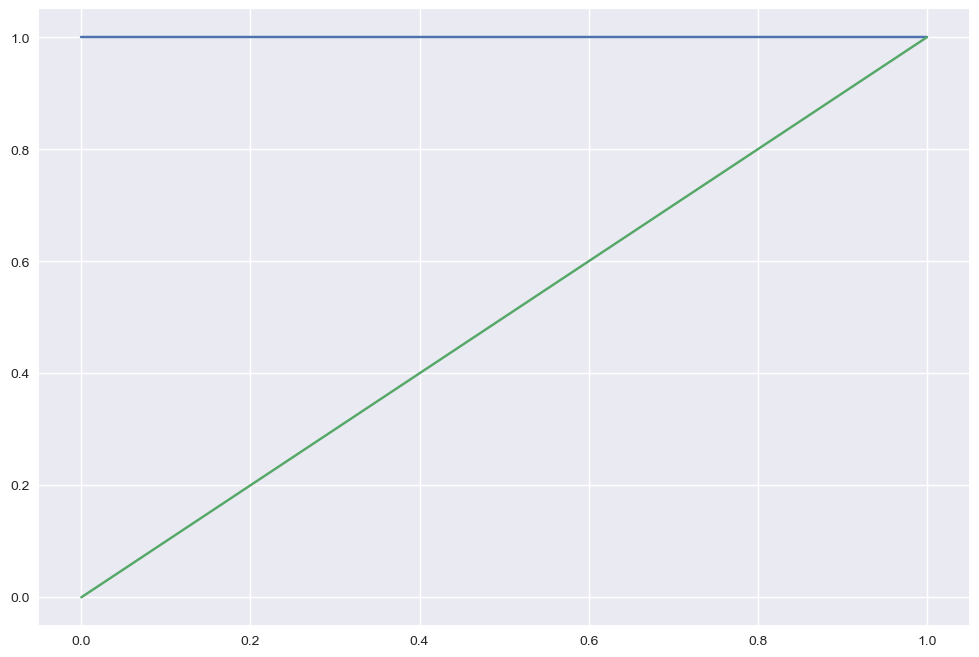

In [73]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)

x = np.linspace(0, 1, 1000)
beta_pdf = beta.pdf(x, 1, 1)
beta_cdf = beta.cdf(x, 1, 1)

plt.plot(x, beta_pdf)
plt.plot(x, beta_cdf)
plt.show()

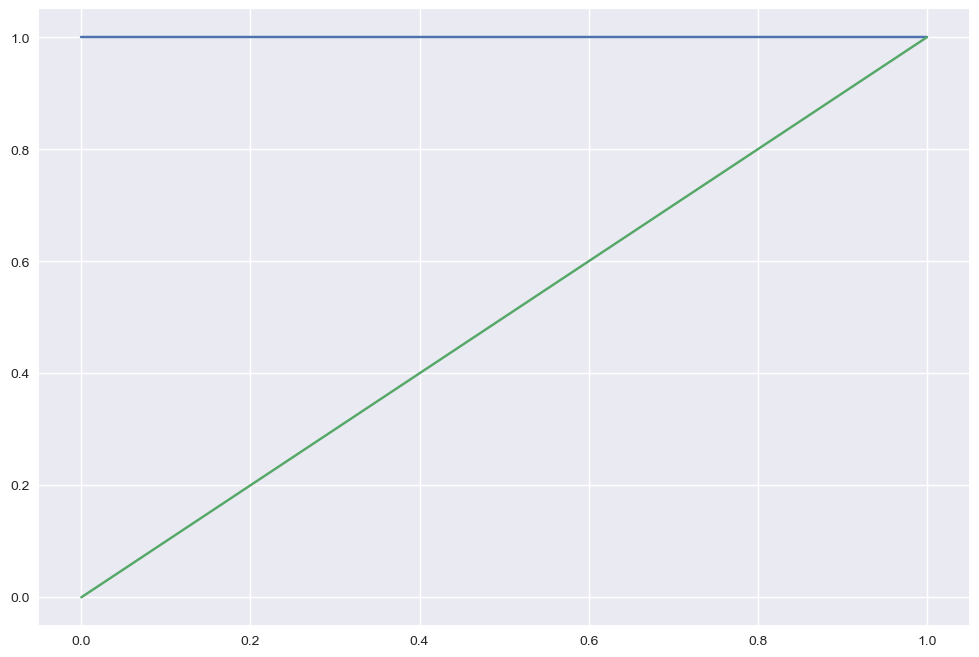

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\scipy\stats\_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


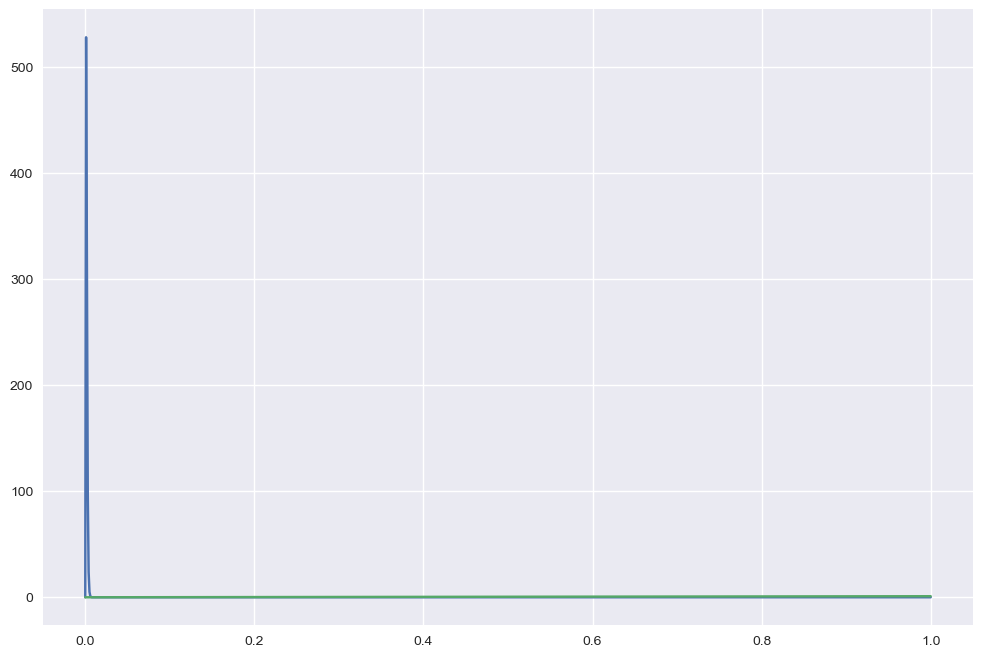

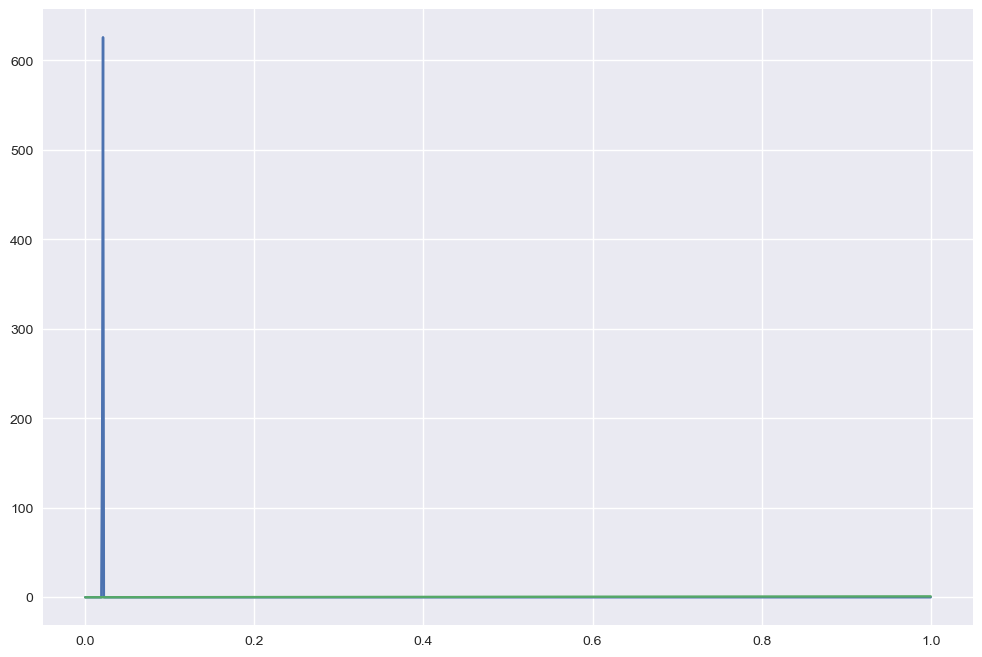

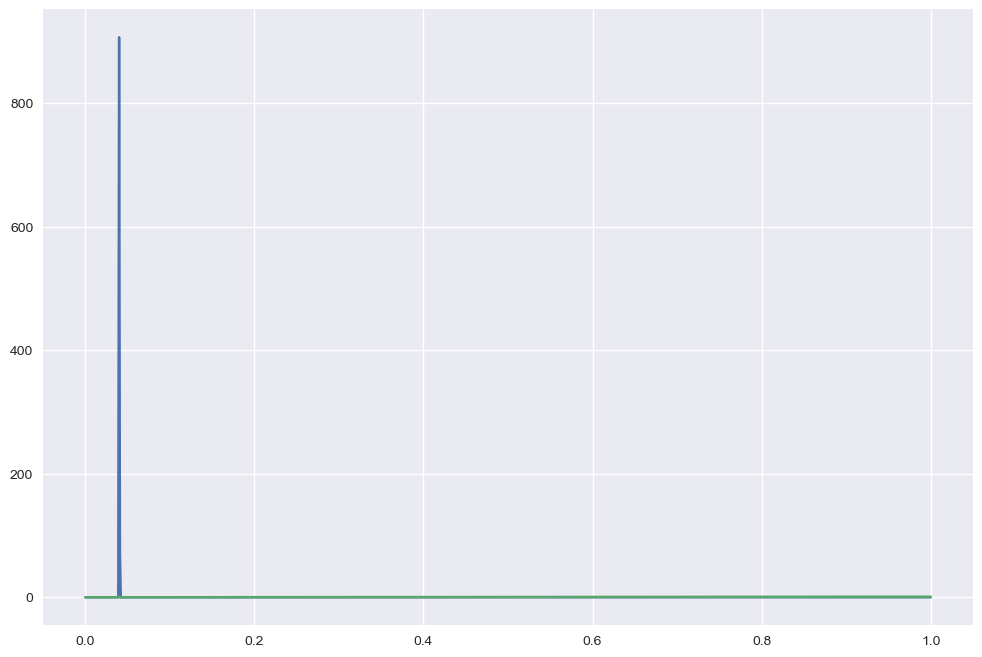

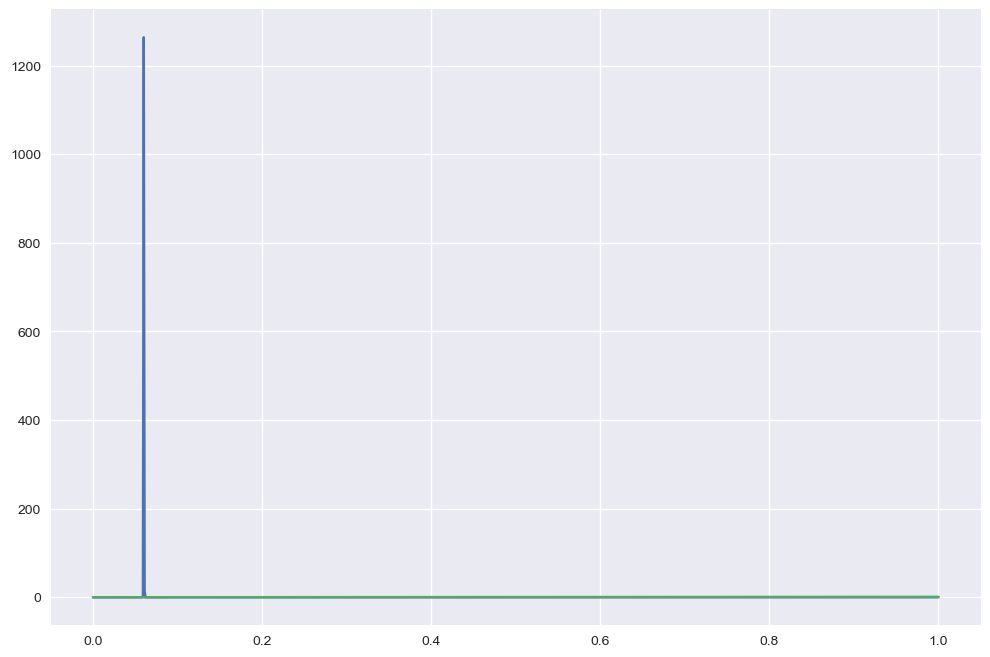

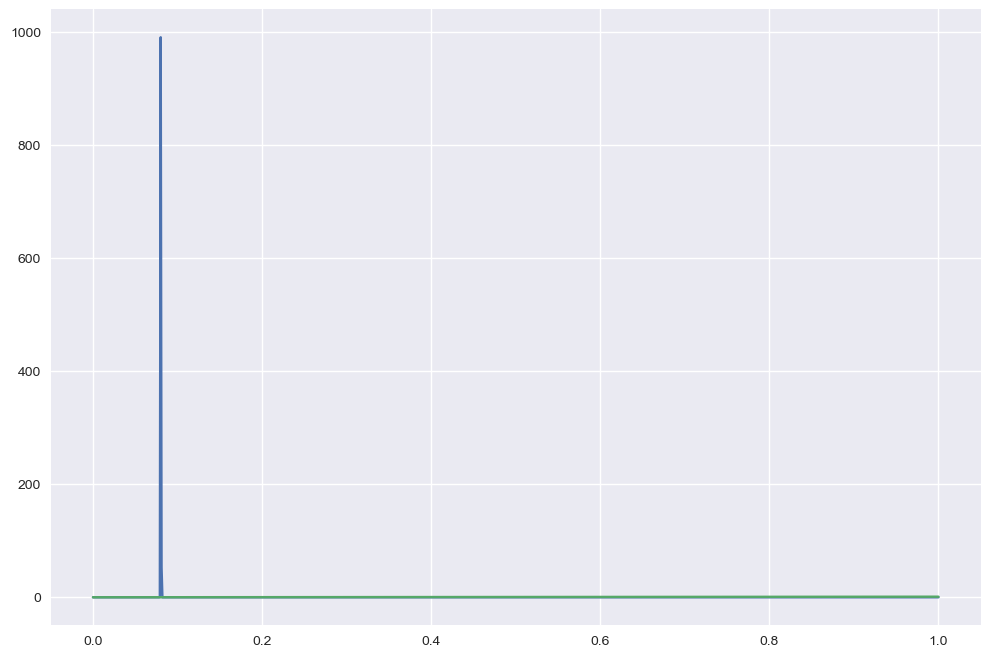

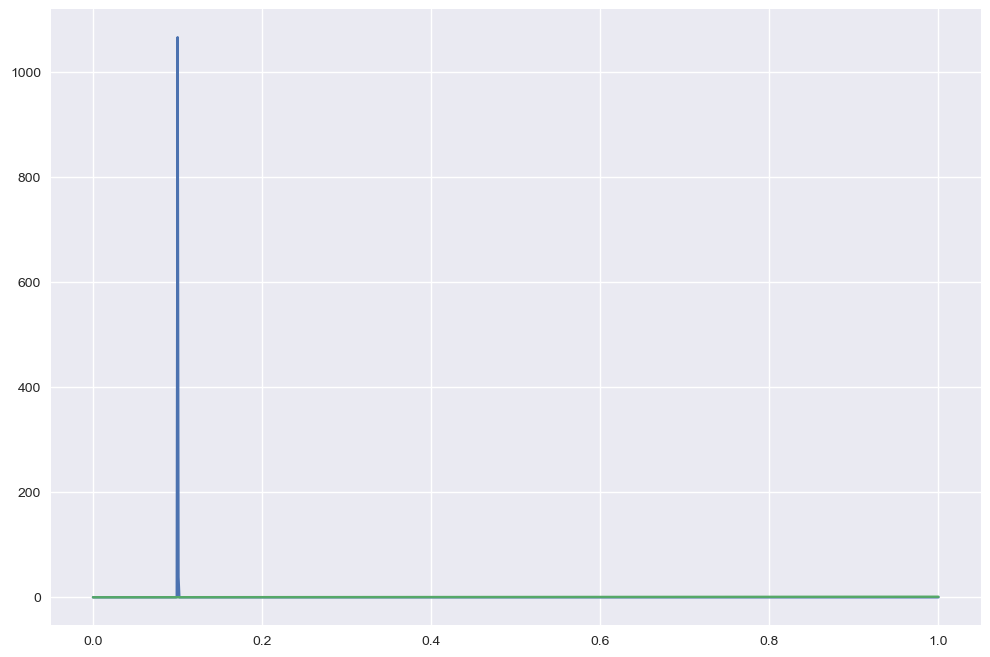

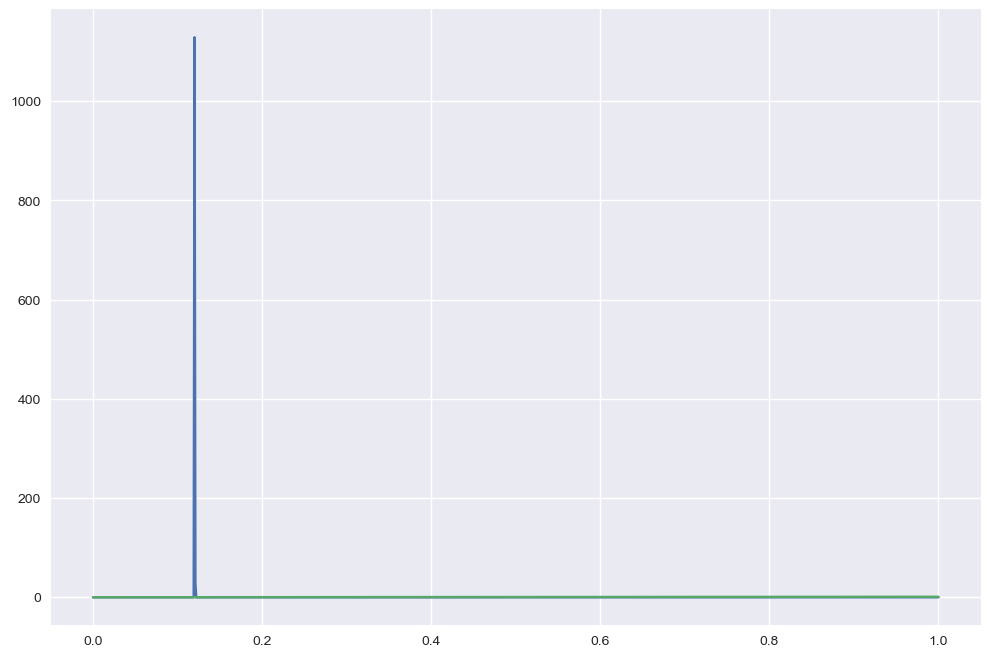

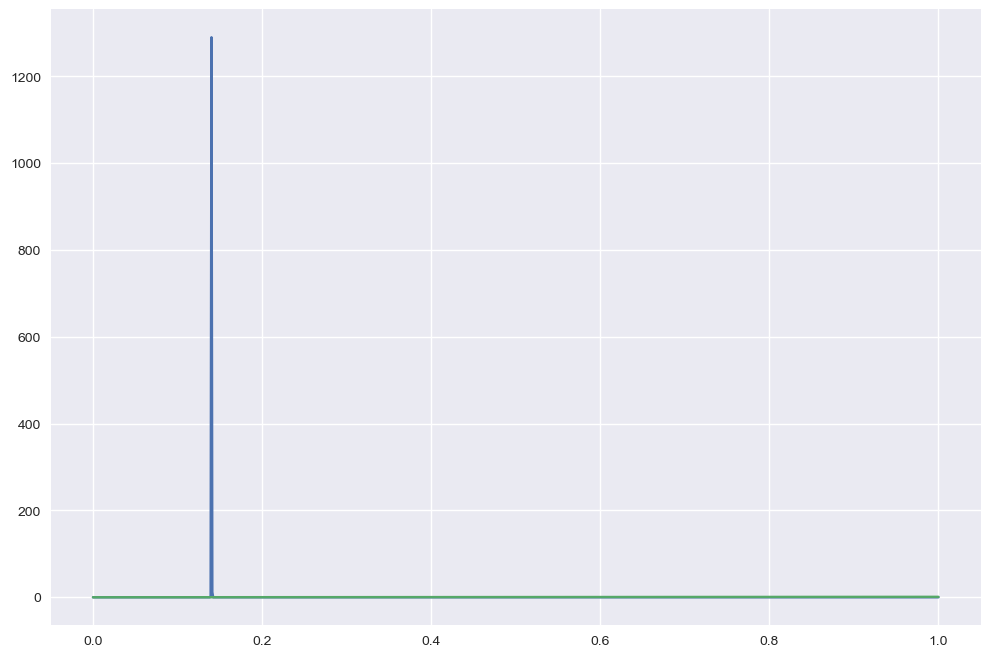

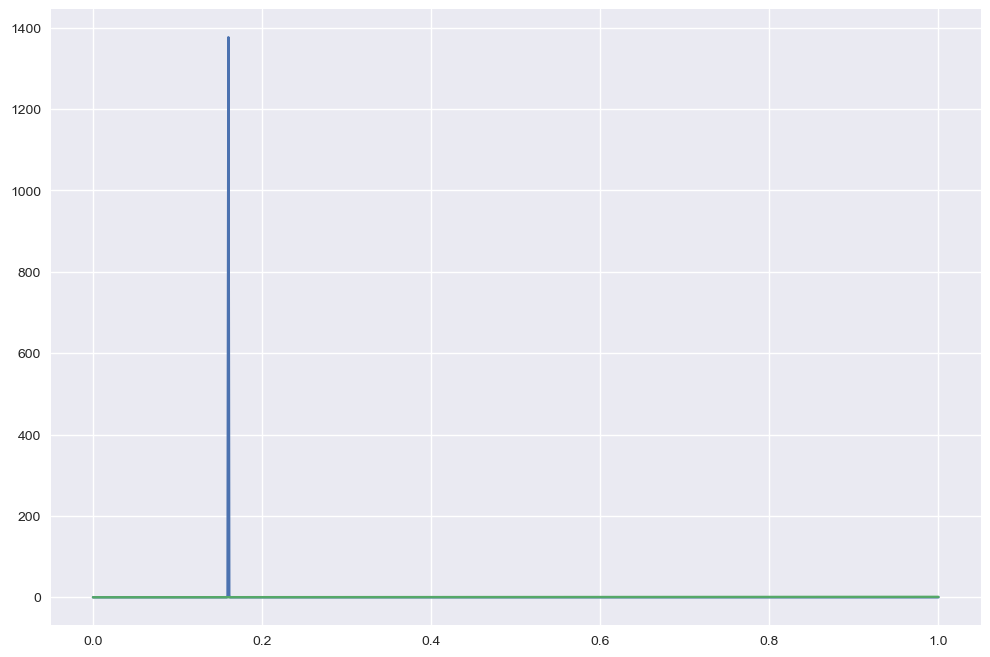

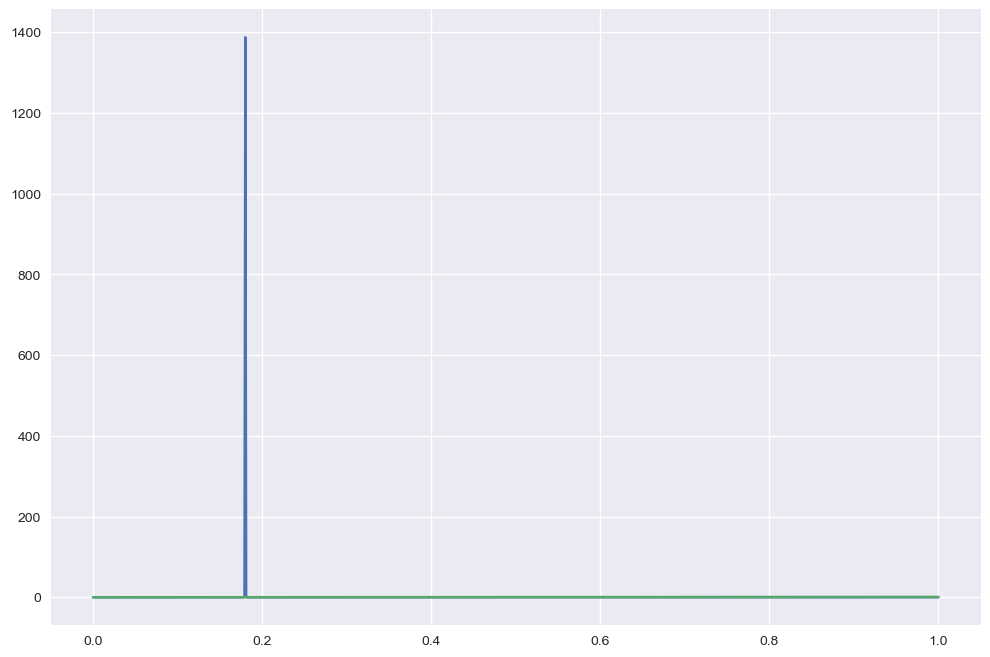

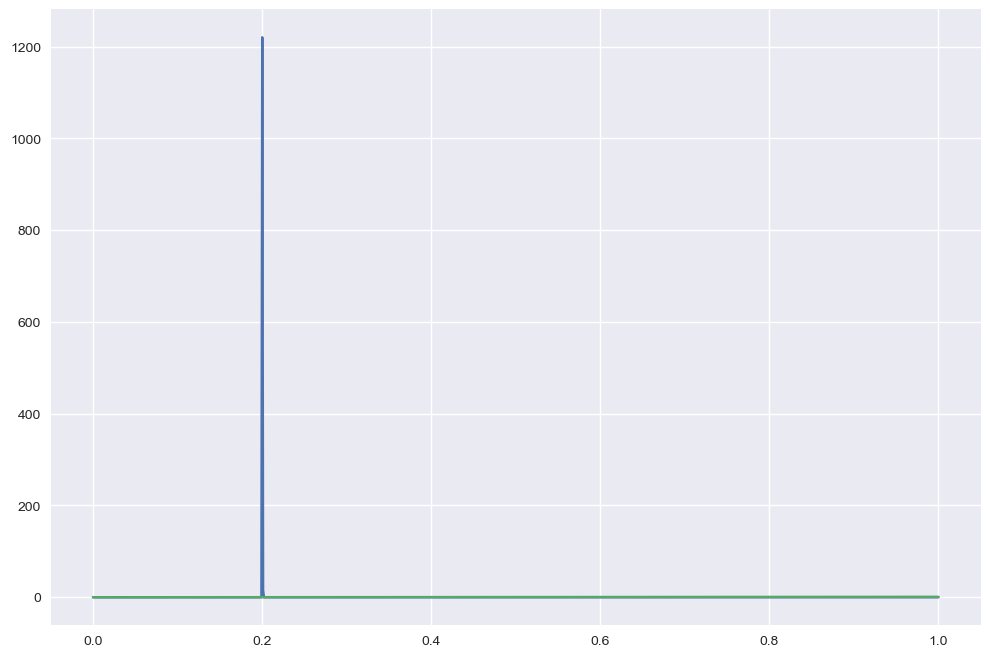

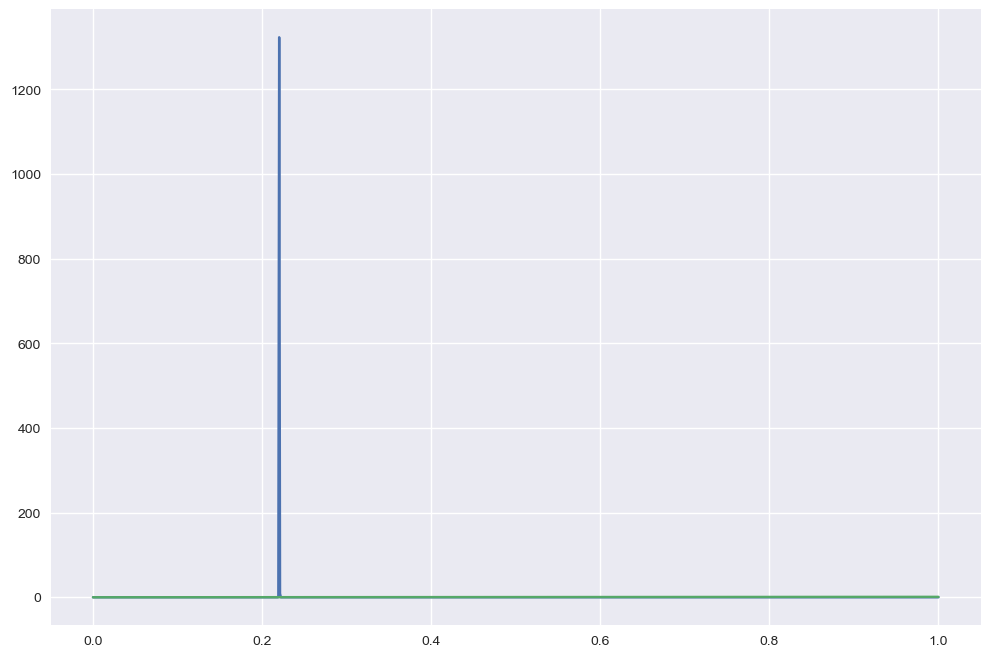

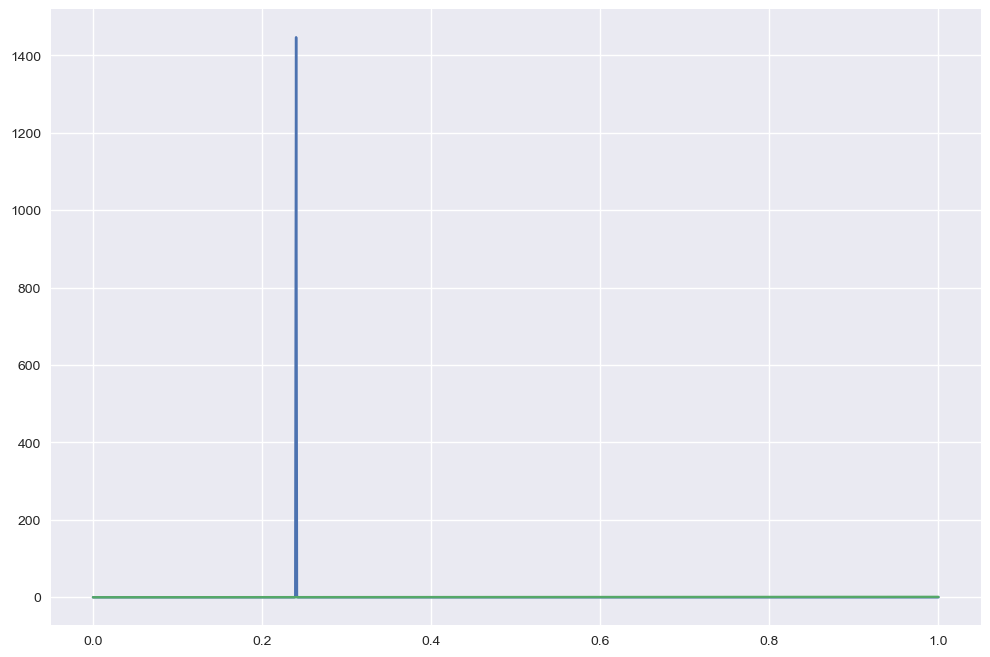

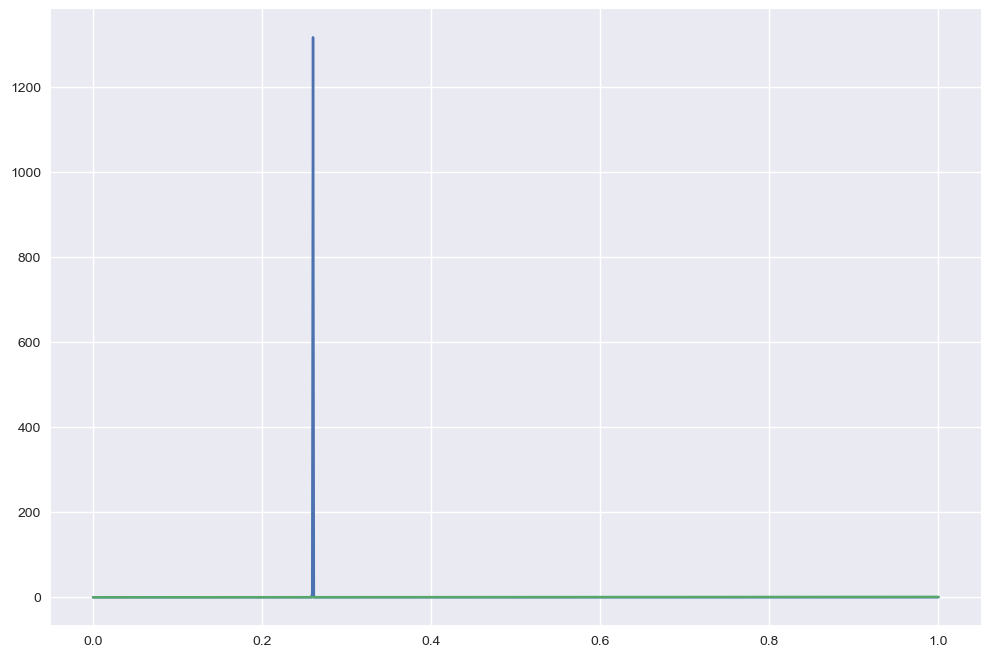

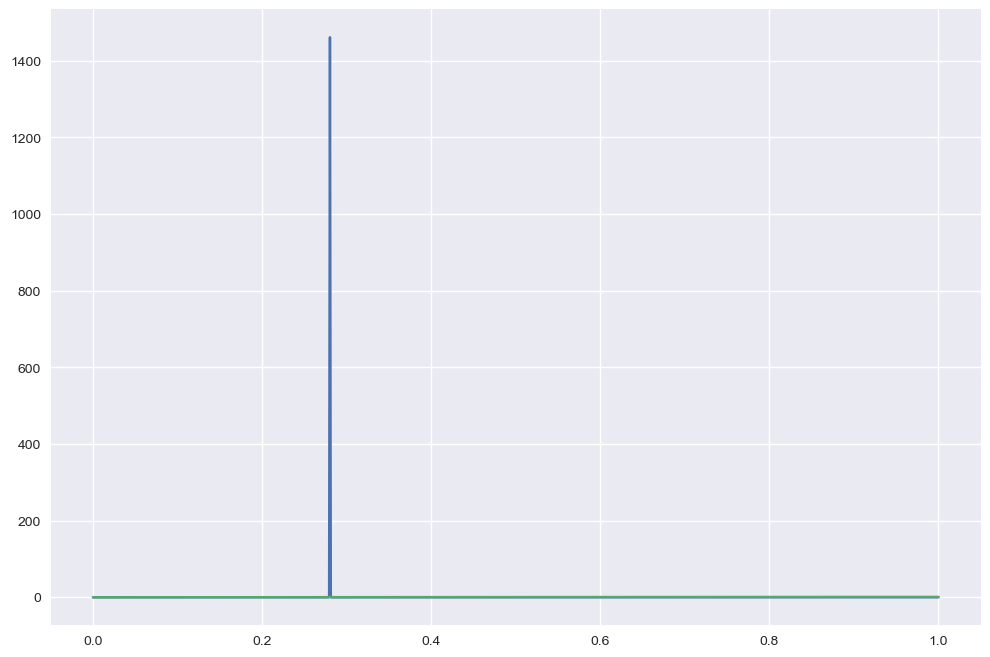

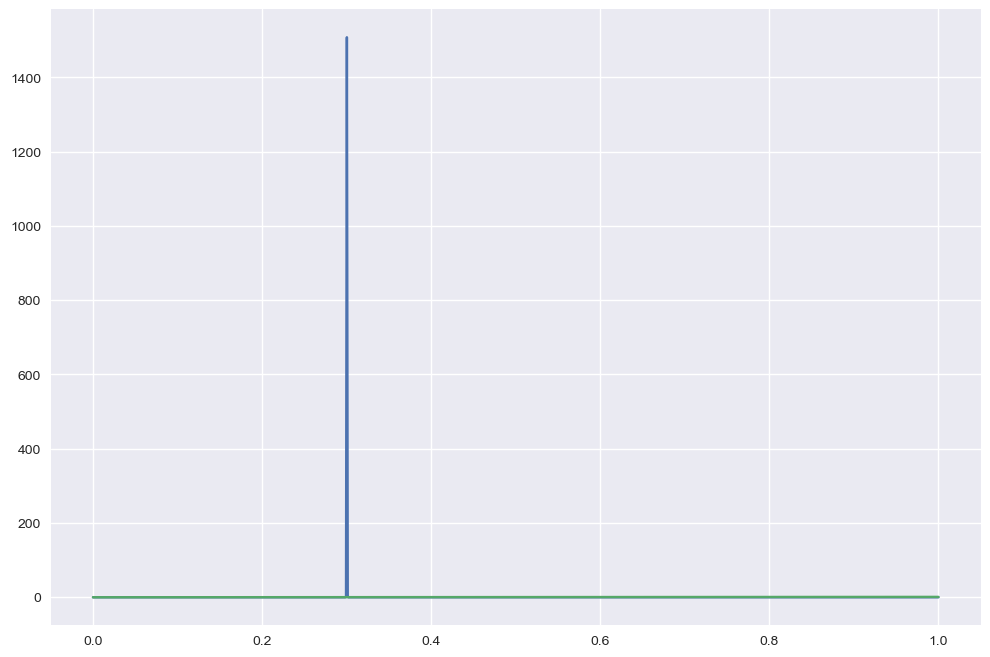

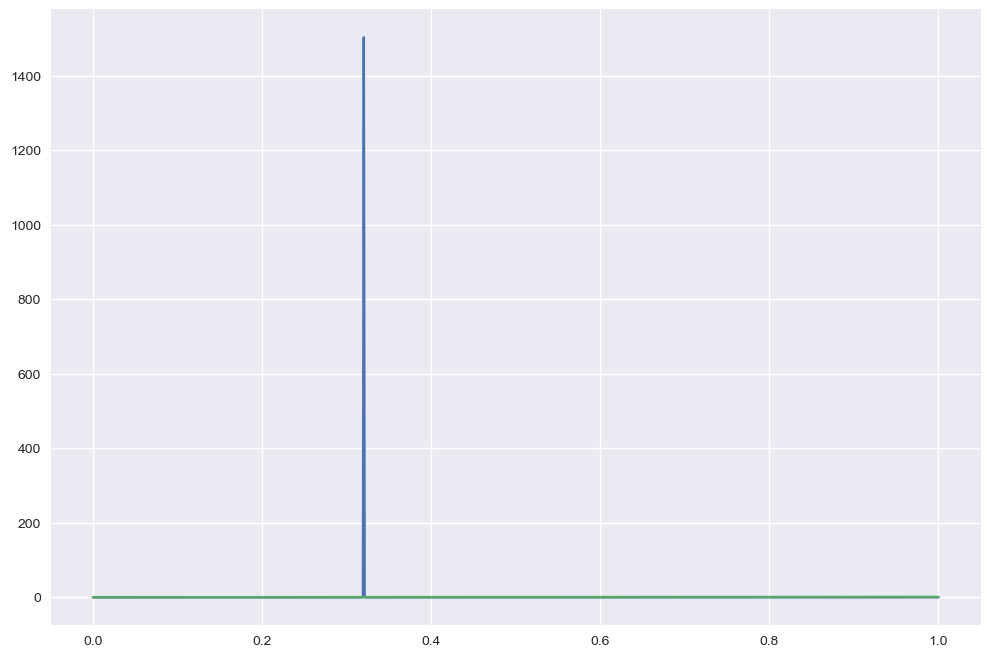

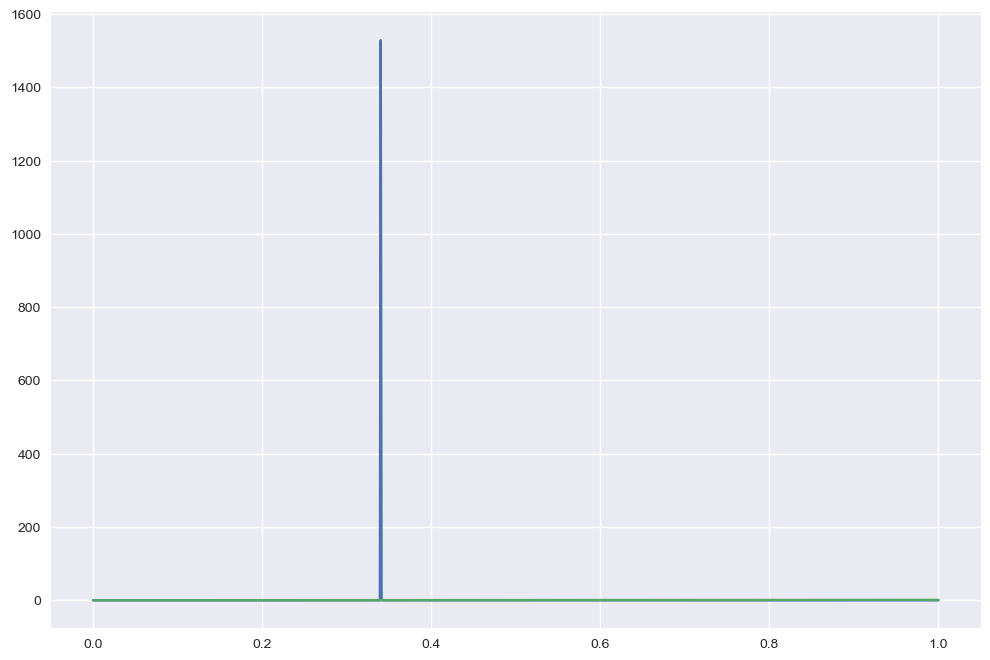

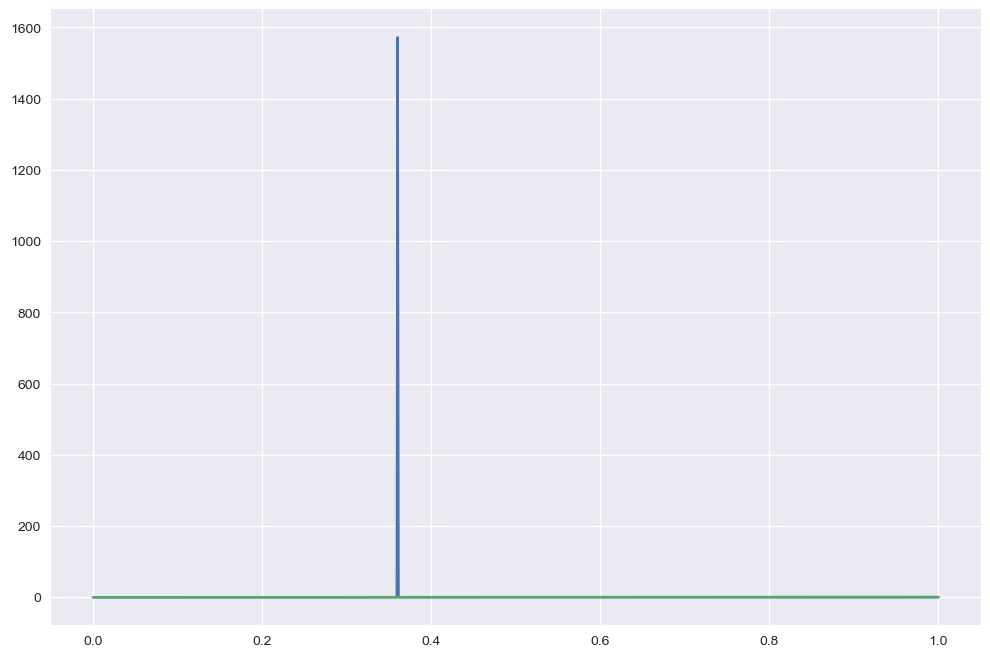

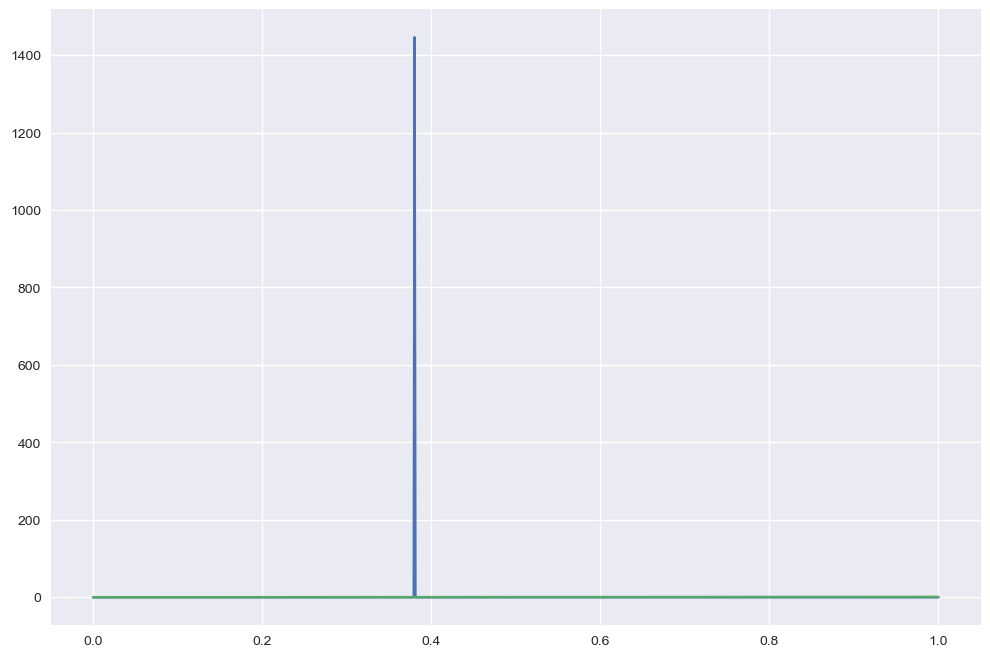

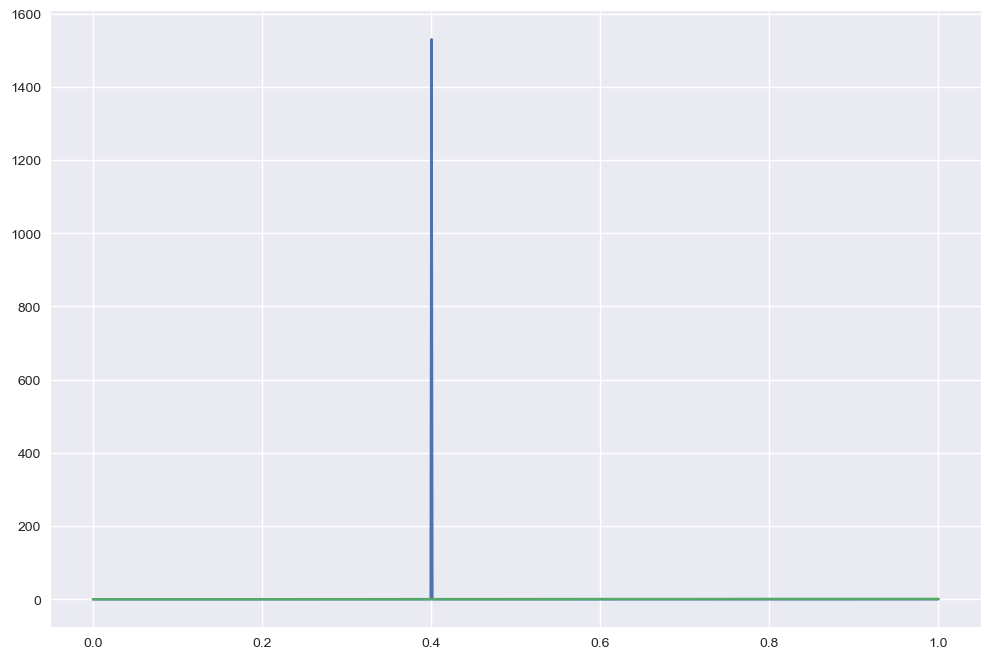

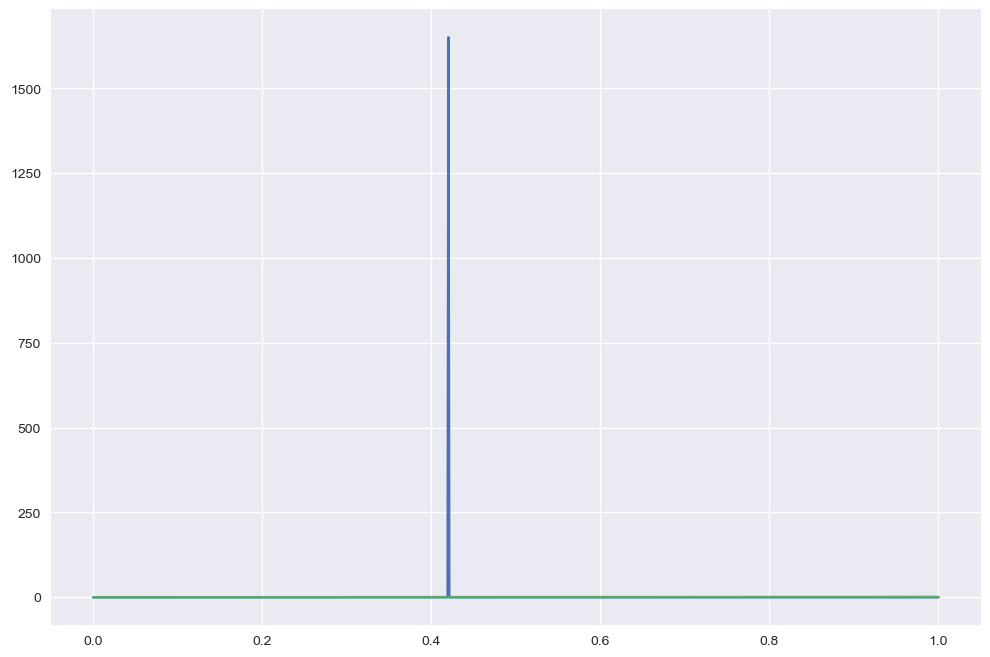

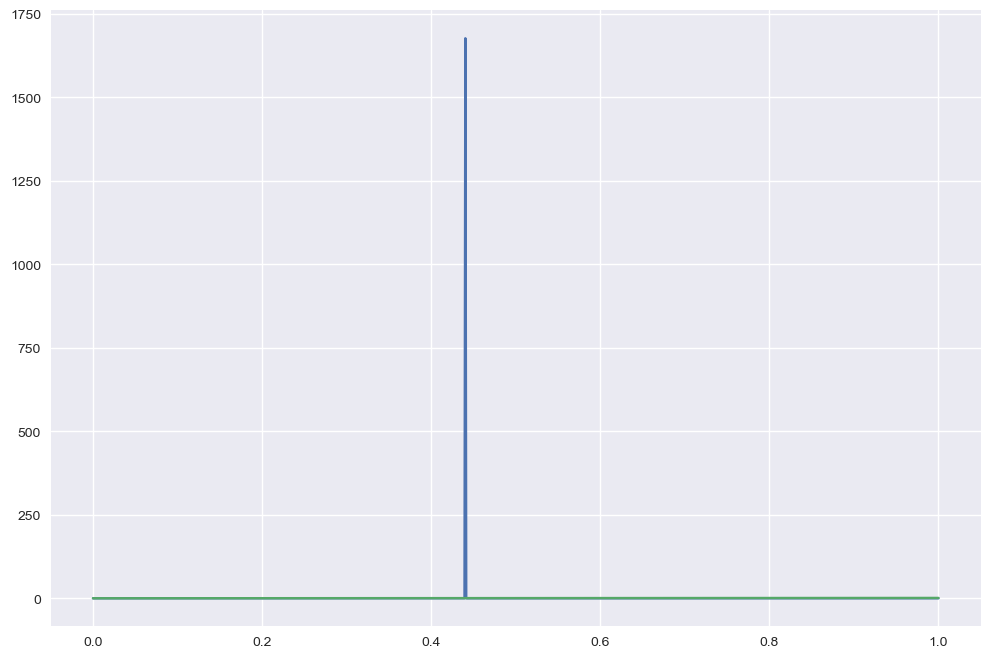

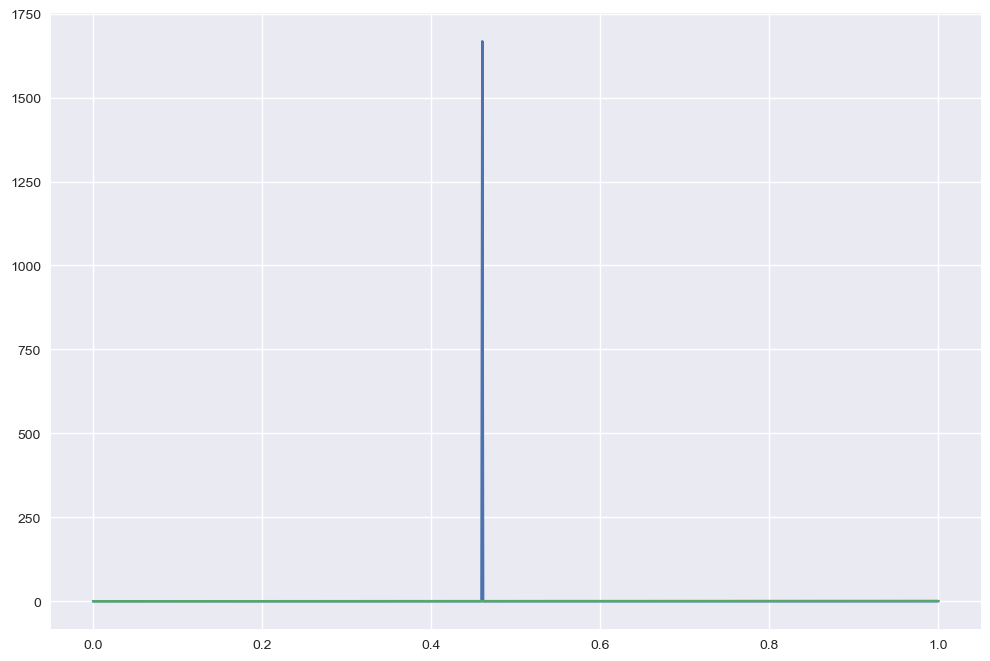

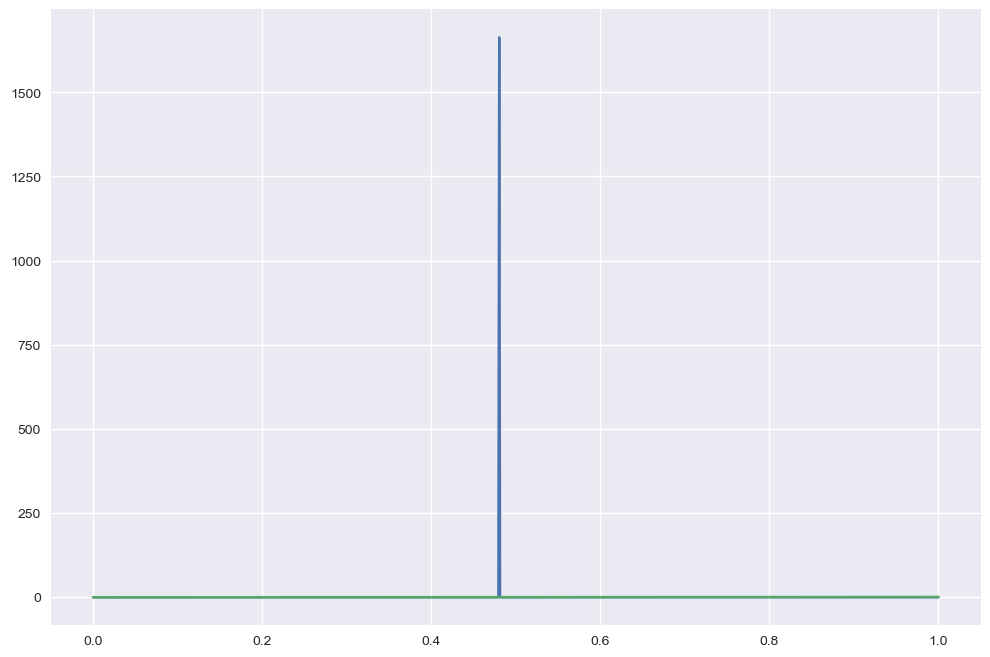

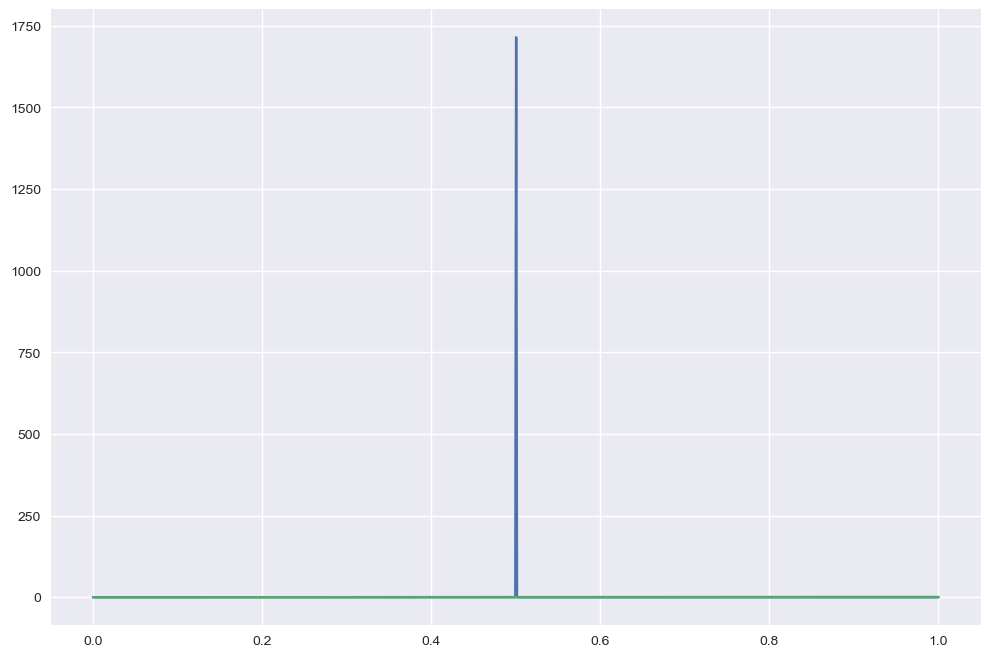

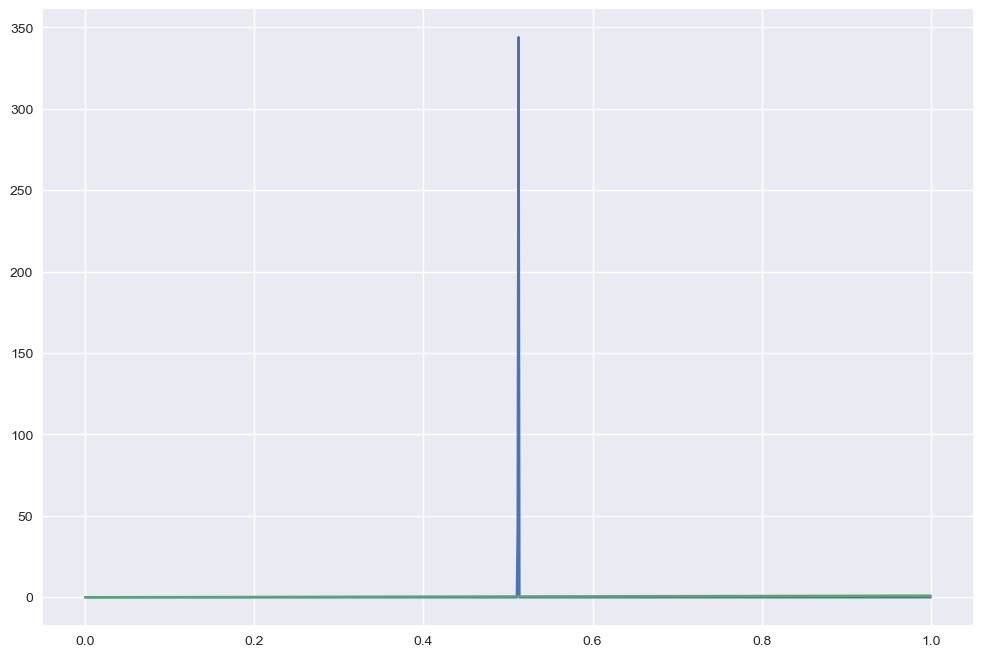

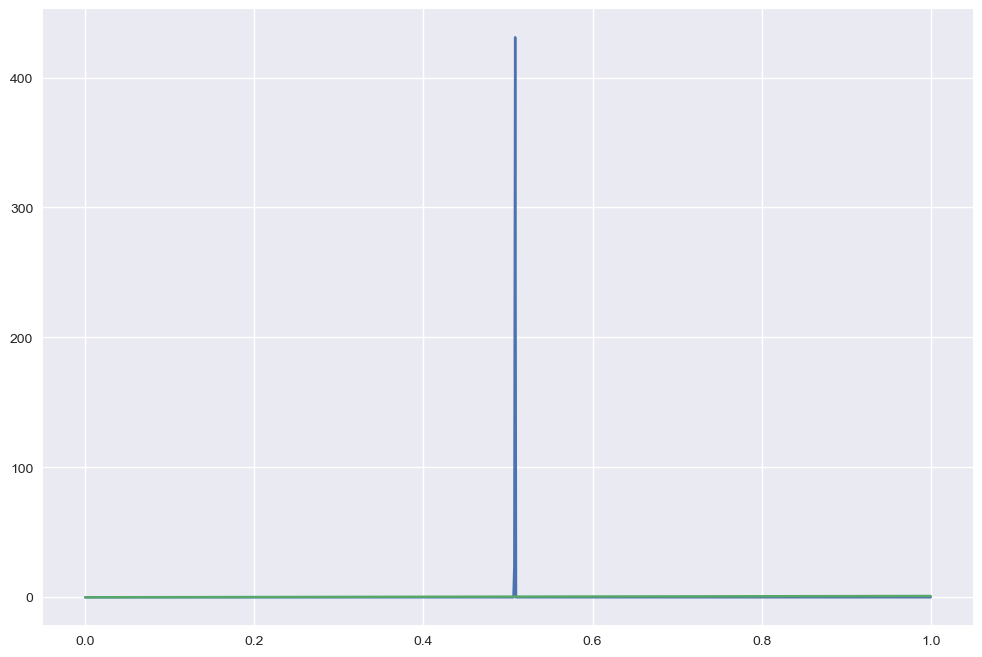

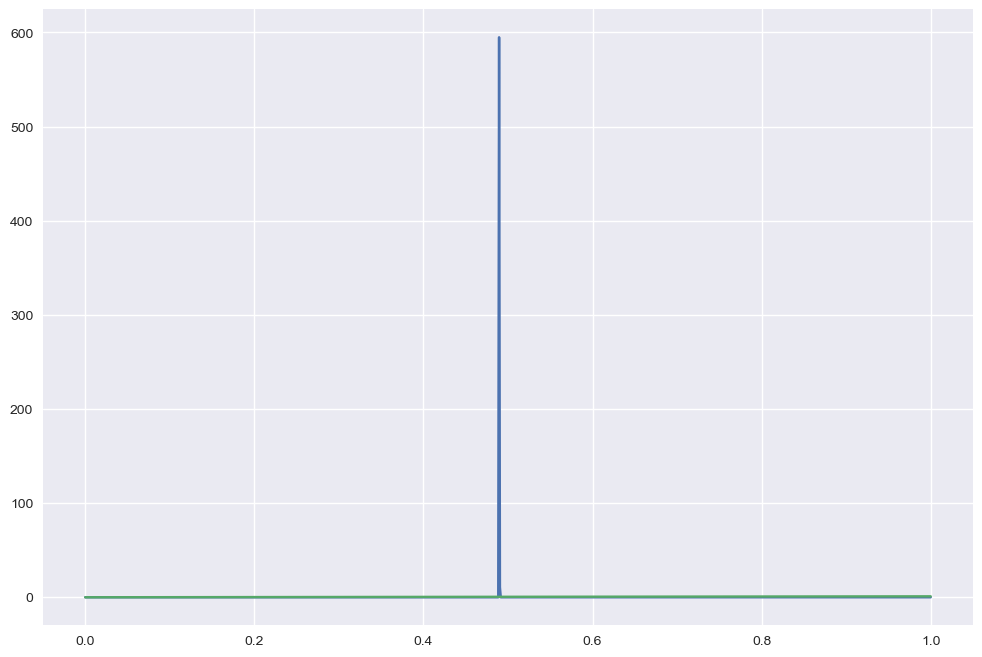

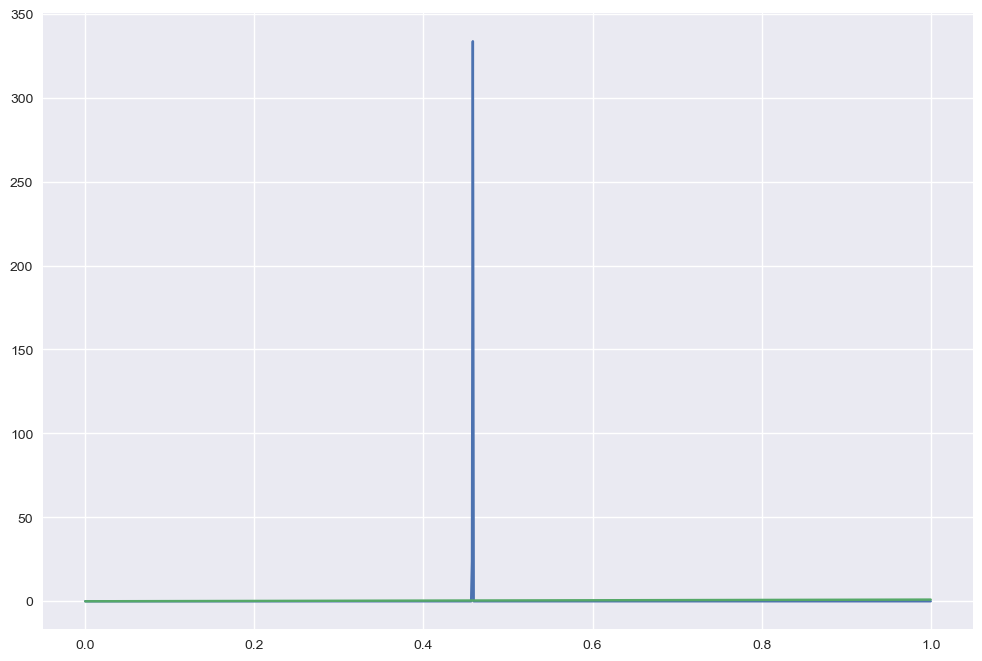

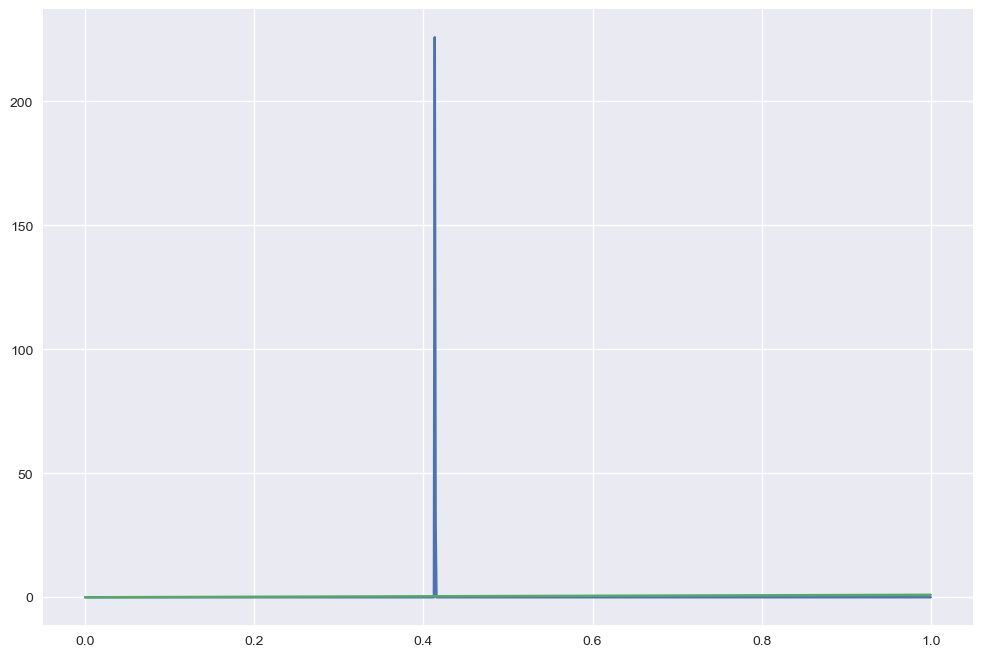

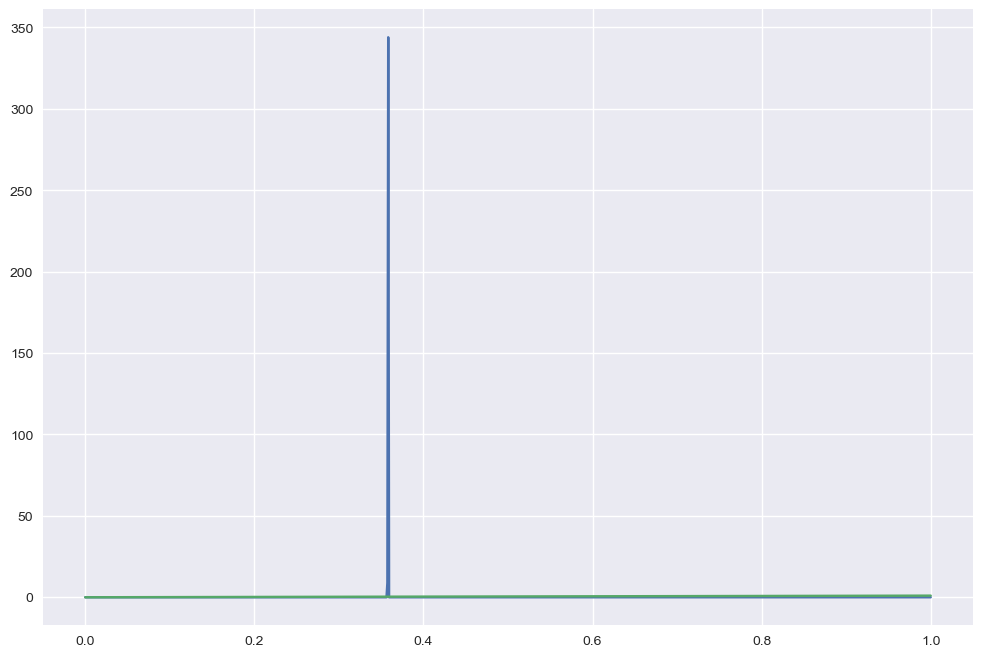

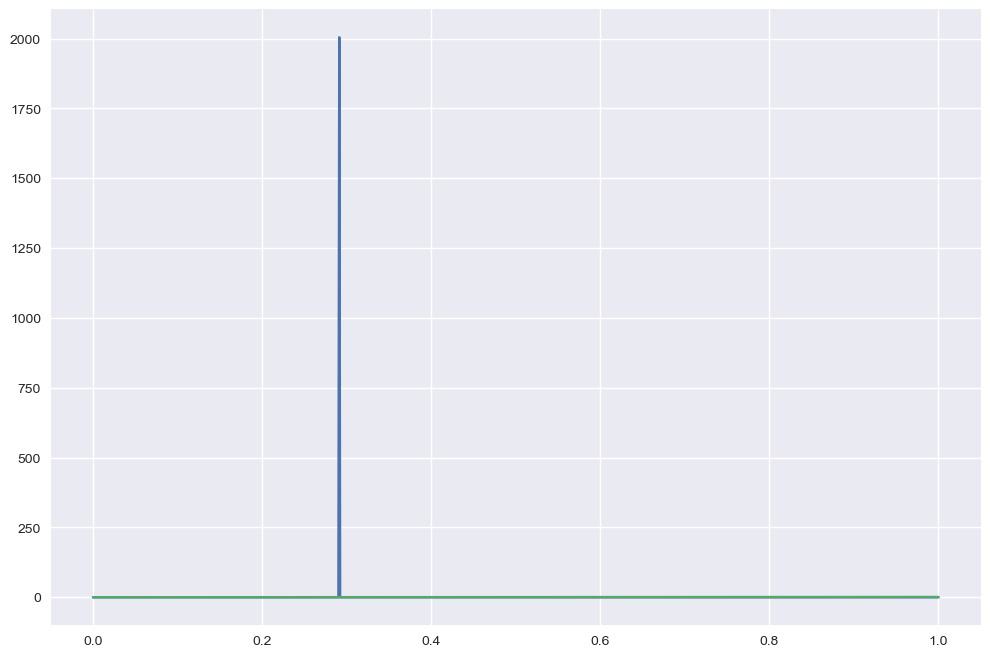

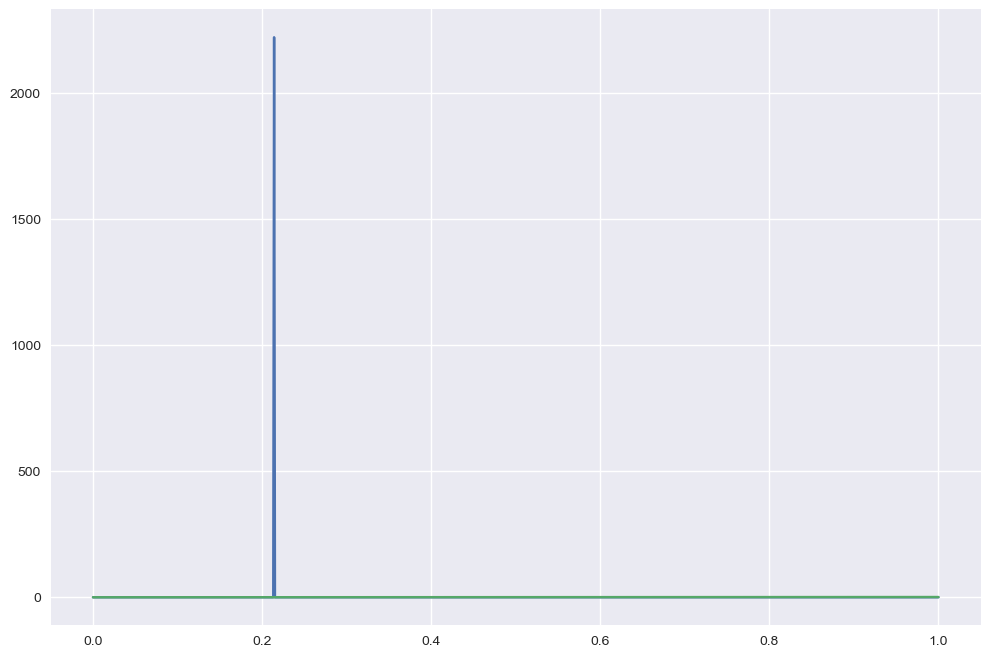

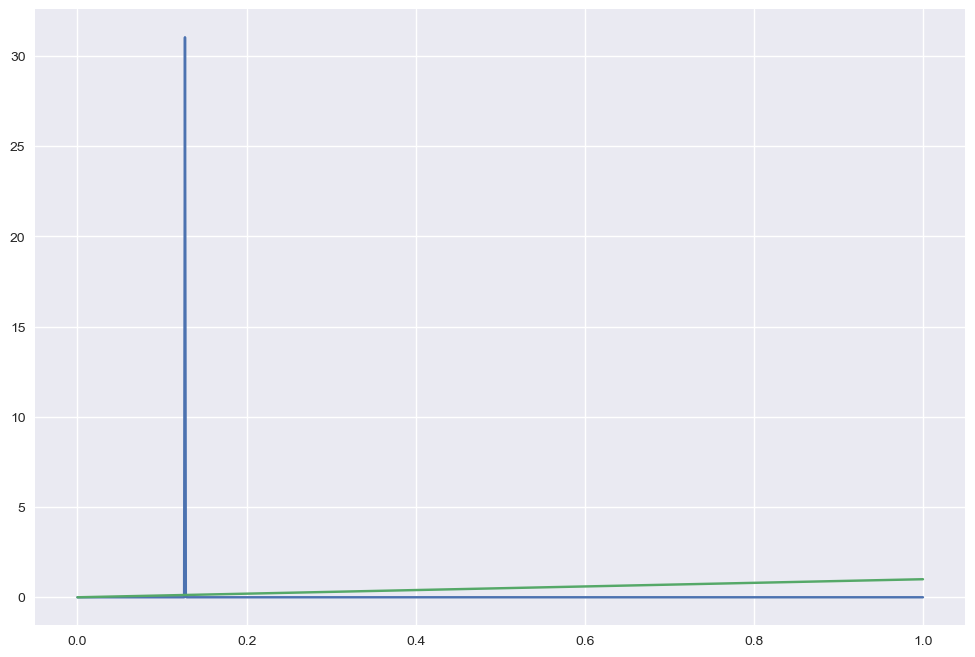

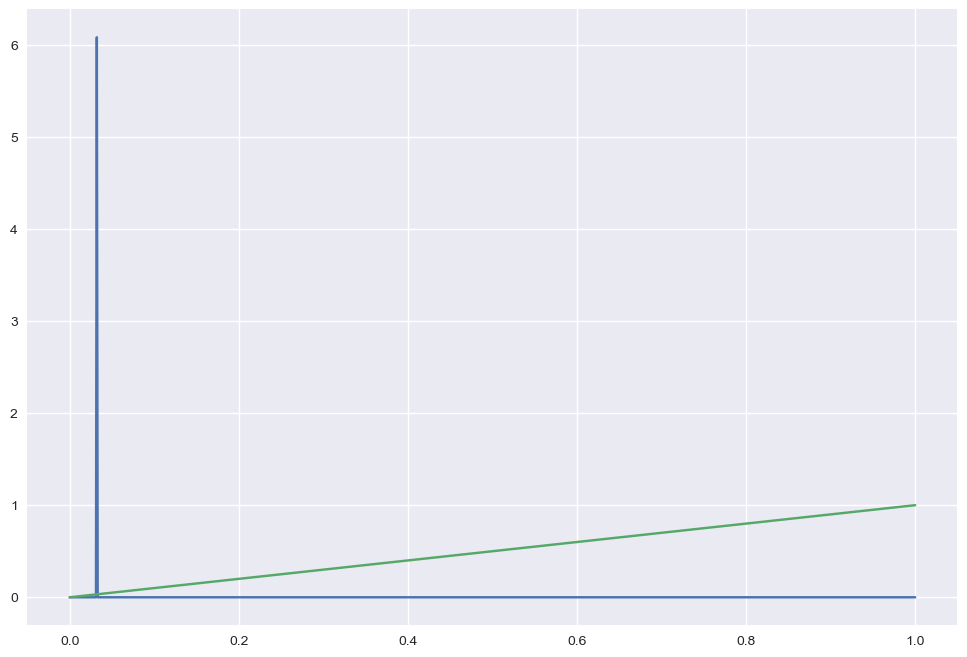

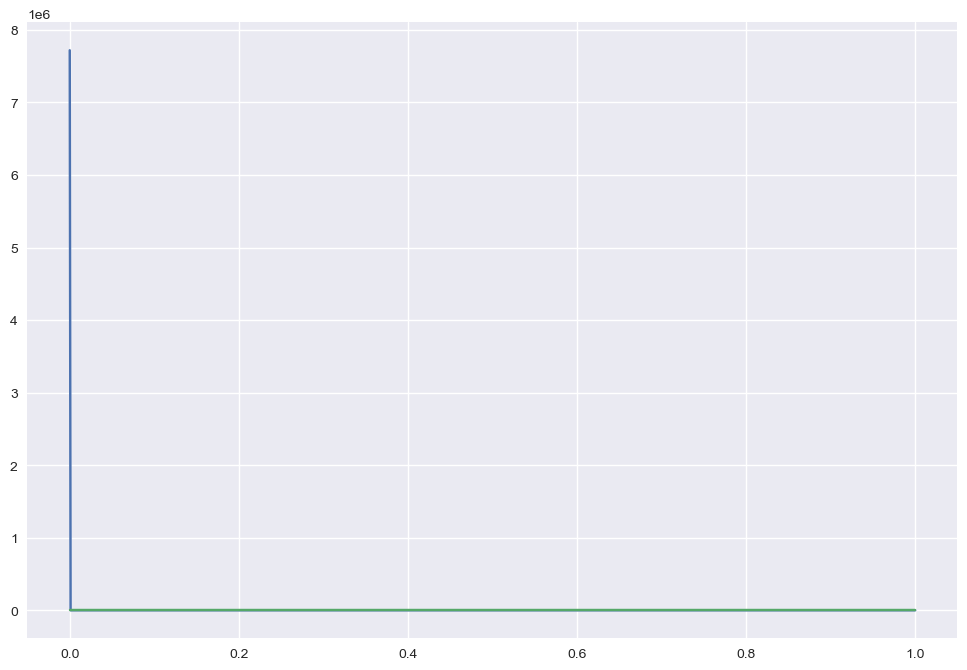

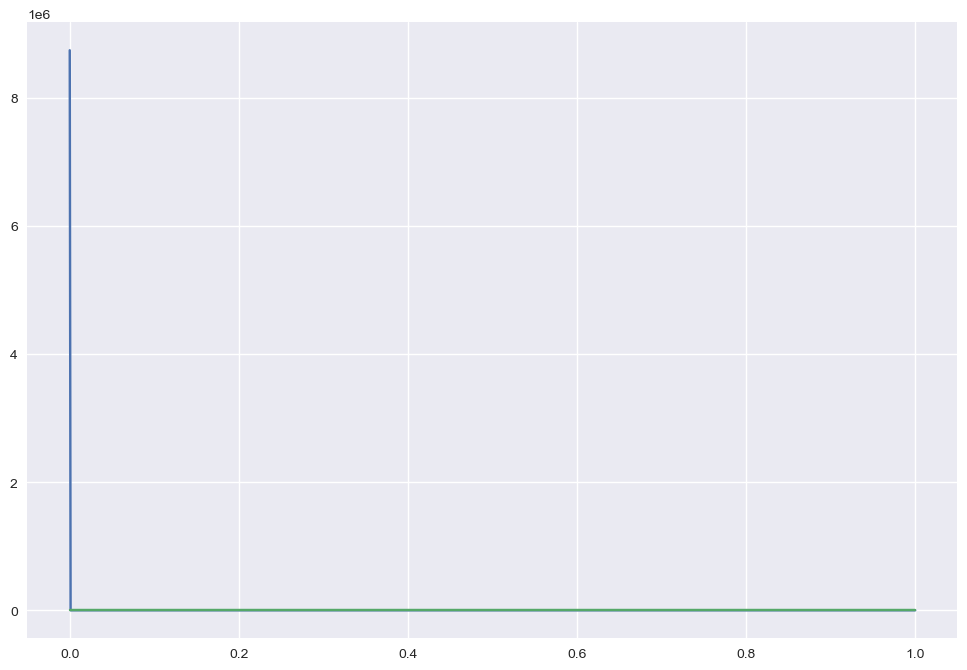

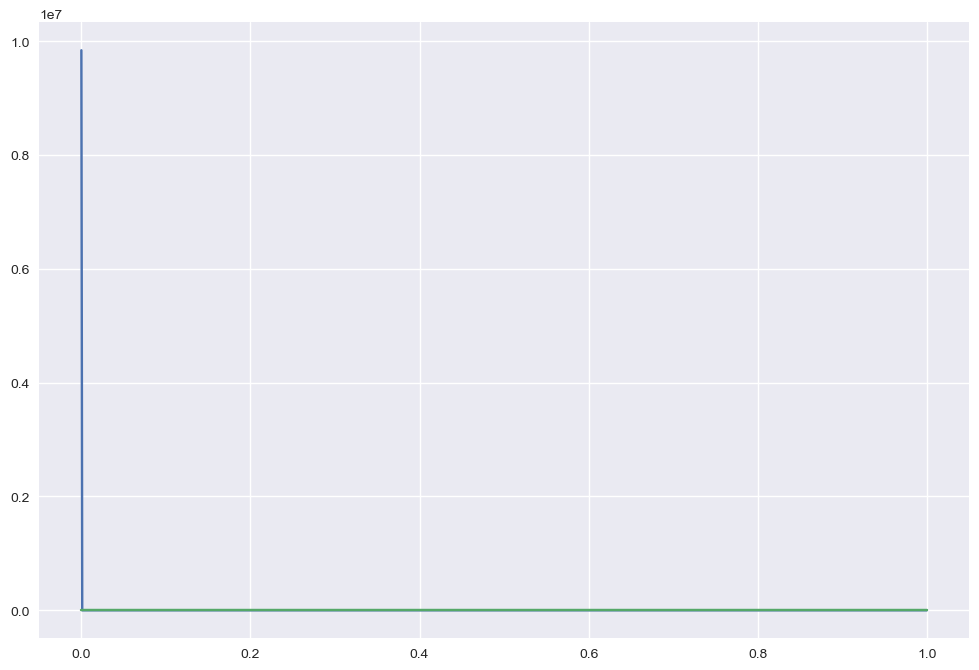

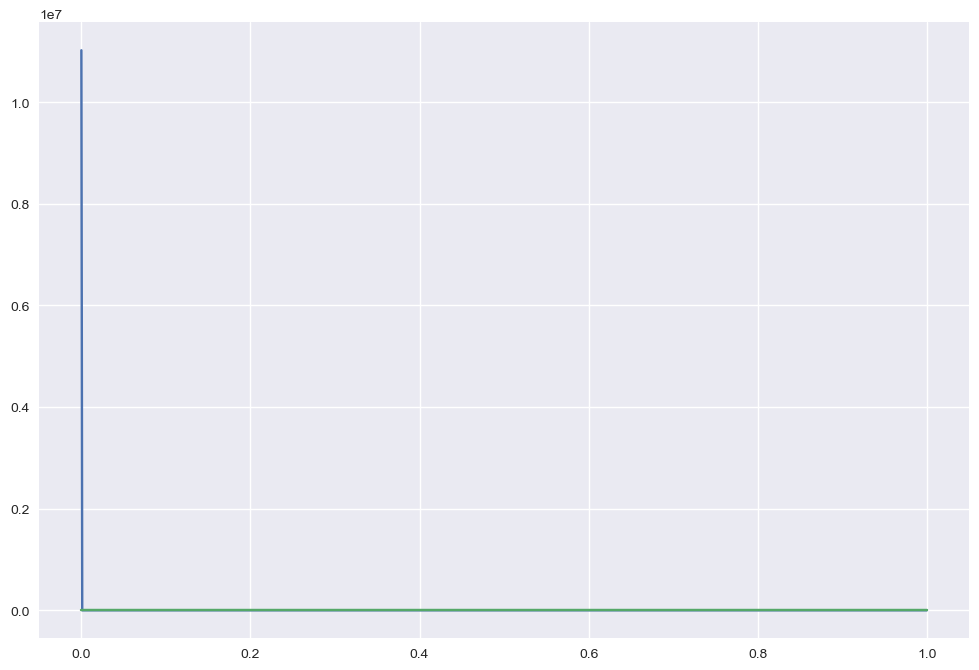

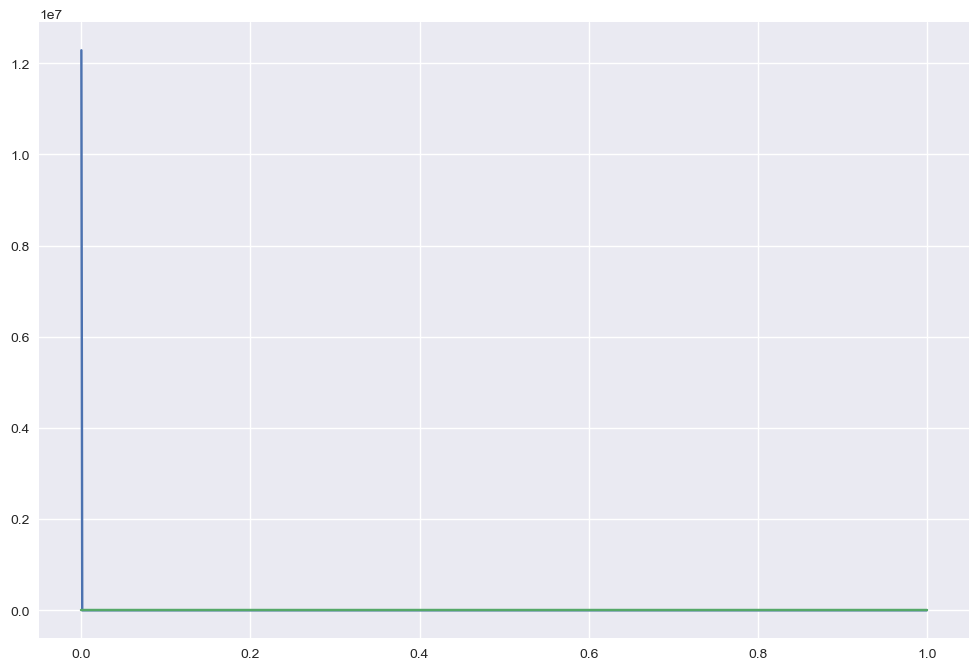

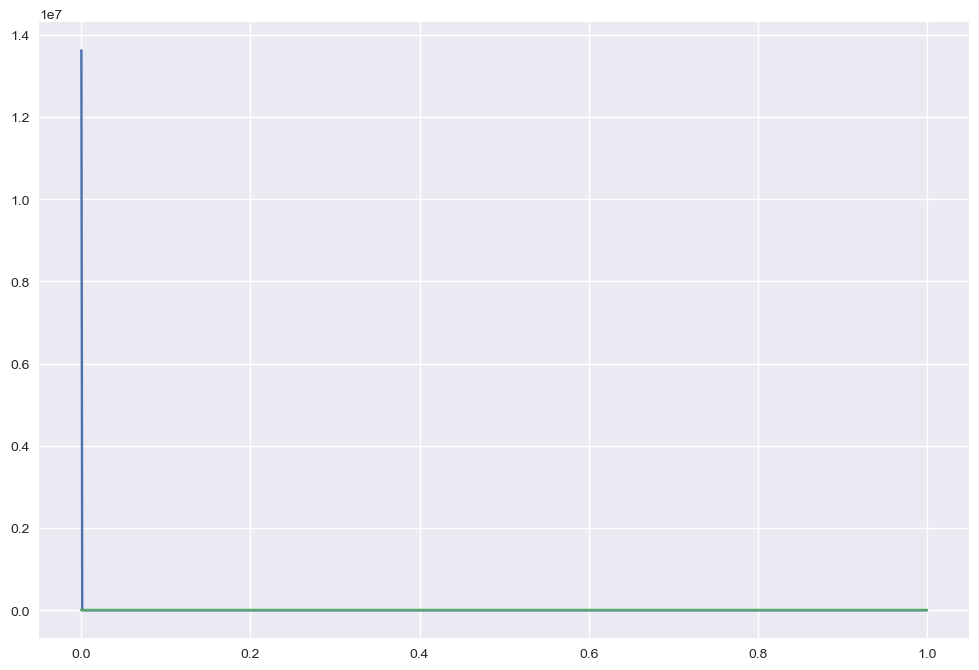

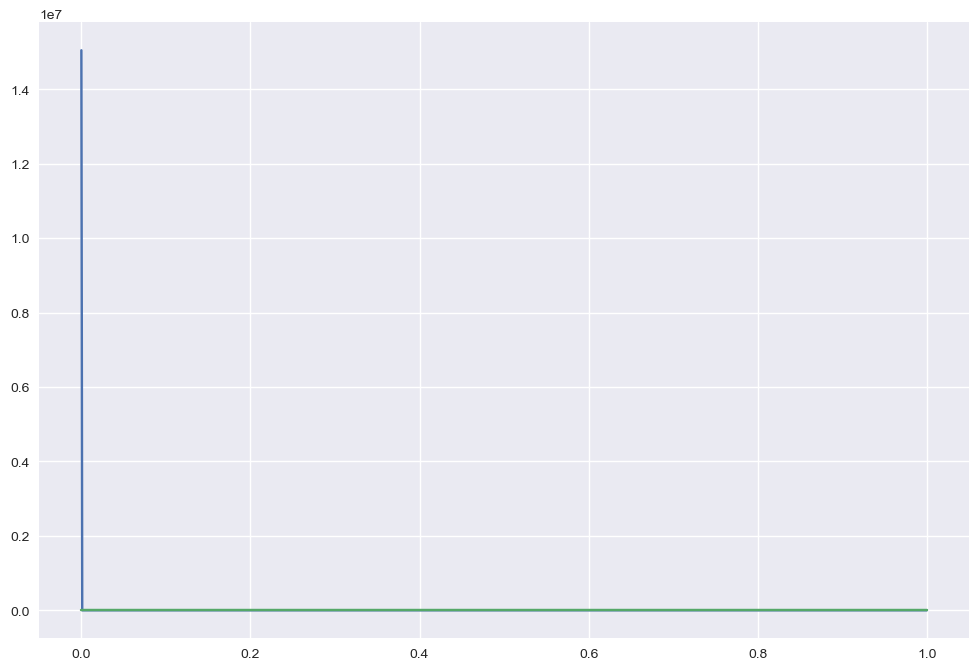

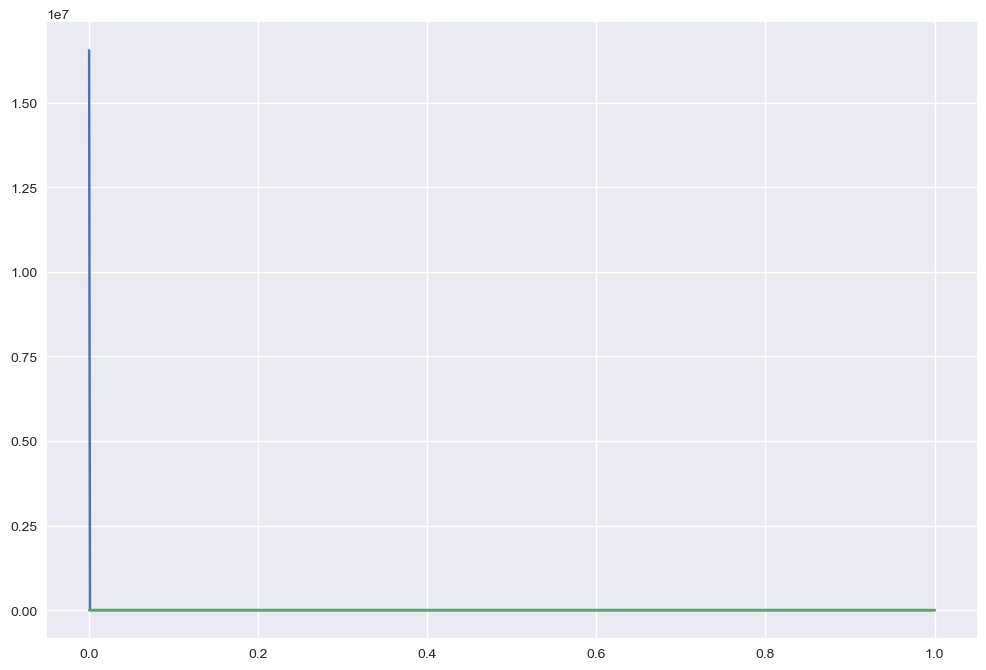

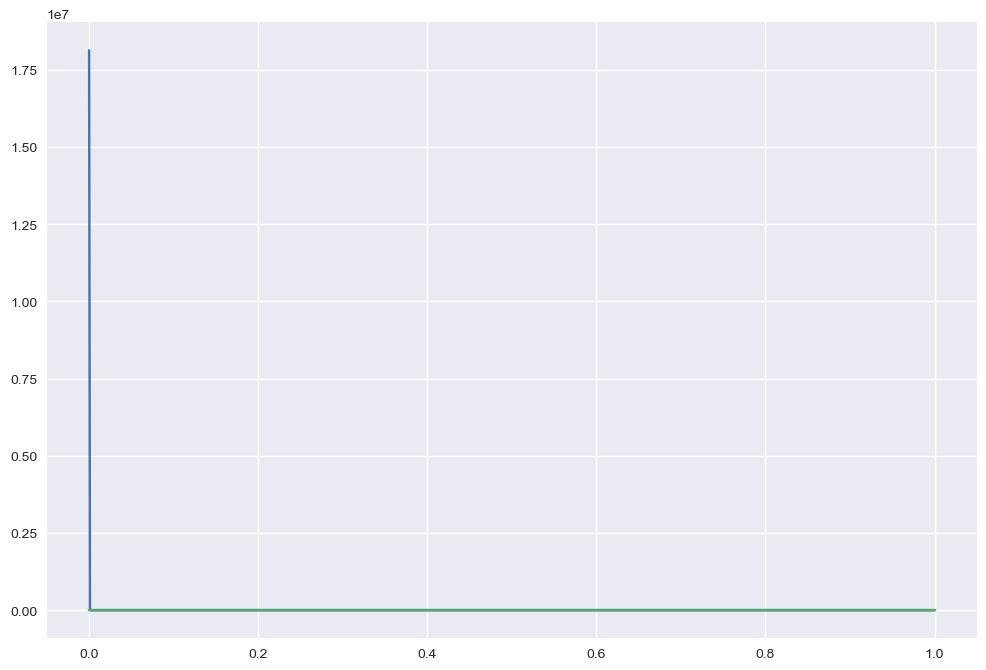

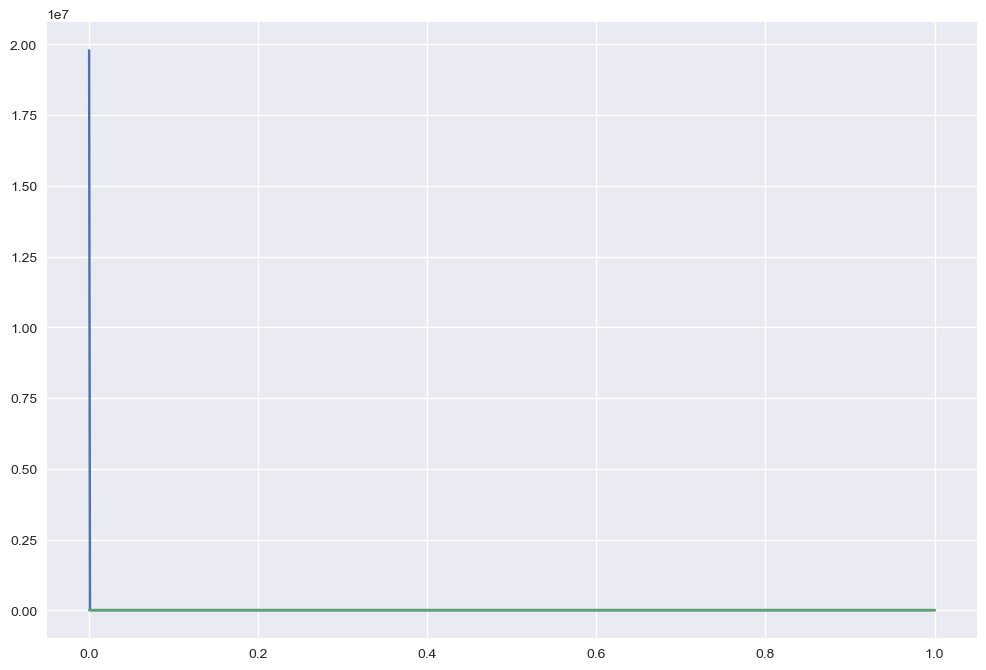

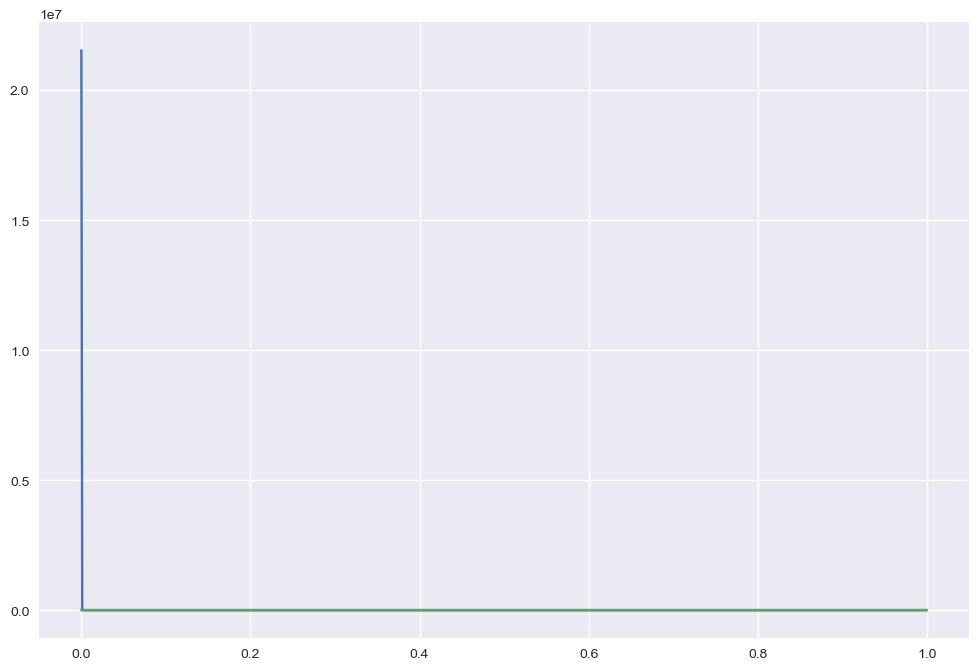

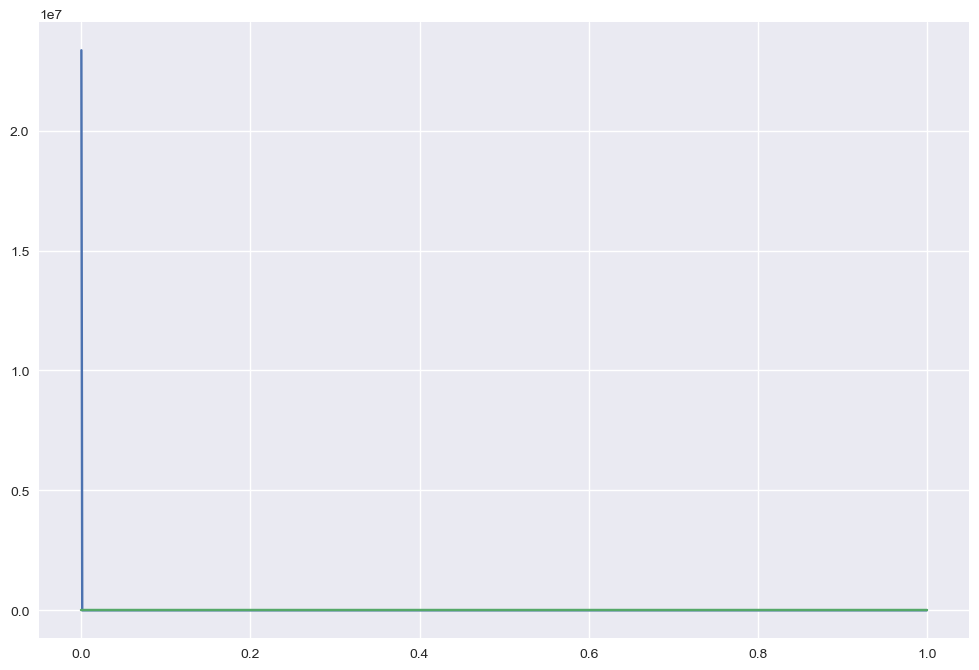

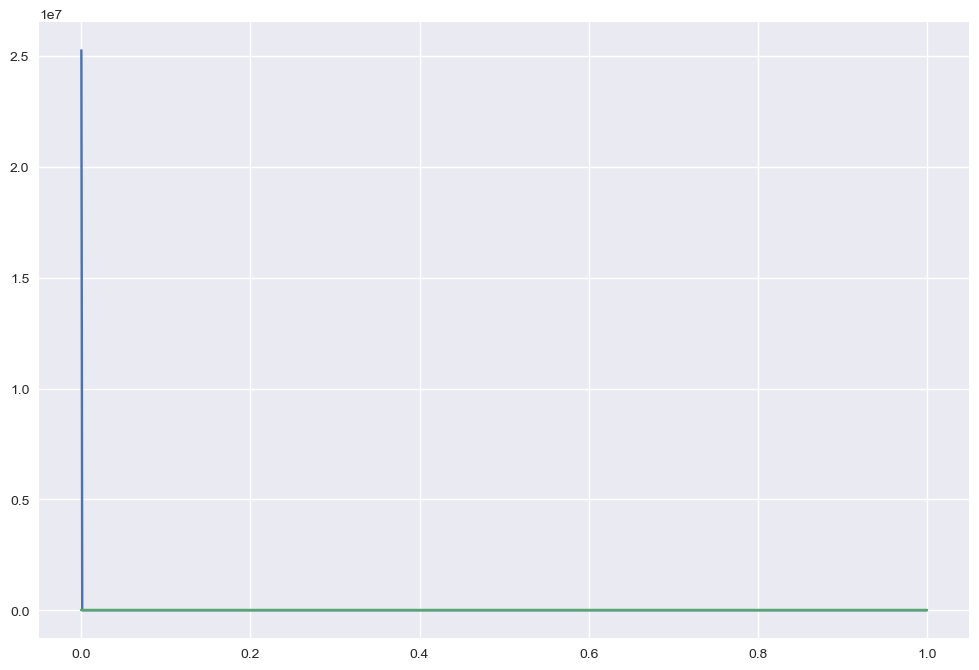

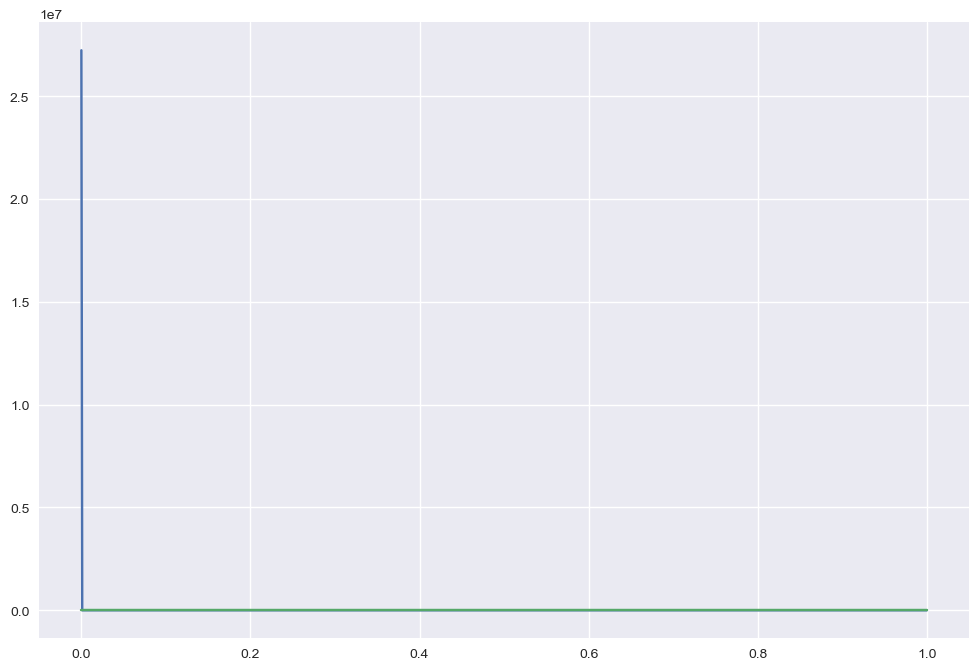

In [76]:
t = 0
d = 0

N = 1000 # number of random variables in a random sample
n = 10000 # number of random samples
alpha0, beta0 = 1, 999 # initial alpha, beta hyperparameters
yab_list = [] # keeps track the number of blues per iteration

xt = np.linspace(0, 1, 1000)
beta_pdf = beta.pdf(xt, 1, 1)
plt.plot(xt, beta_pdf)
plt.plot(xt, beta_cdf)
plt.show()
plt.close()

for i in range(n):
    d = D(d, i+1)
    p = beta.rvs(alpha0, beta0, size=N)
    x = bernoulli.rvs(p)
    y = np.sum(x)
    alpha0, beta0 = dynamic(alpha0, beta0, d, i+1, y, N)
    if i % 200 == 0:
        yab_list.append((y, alpha0, beta0))
        
        xt = np.linspace(0, 1, 1000)
        beta_pdf = beta.pdf(xt, alpha0, beta0)
        #beta_cdf = beta.cdf(xt, alpha0, beta0)

        plt.plot(xt, beta_pdf)
        plt.plot(xt, beta_cdf)
        plt.show()
        plt.close()